## XGBoost
순차적으로 트리를 만들면서 이전 트리결과로부터 가중치를 조절하면서 오차를 줄여나가는 부스팅을 쓴다


In [105]:
import pandas as pd
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

In [106]:
def load_dataset(filename):
    df = pd.read_excel(filename)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    return df

In [107]:
sales = load_dataset("sales_train_final.xlsx")

In [108]:
sales
sales.shape

(37368, 37)

In [109]:
sales.dtypes

방송일시                datetime64[ns]
노출(분)                      float64
상품명                         object
상품군                          int64
판매단가                         int64
취급액                          int64
month                        int64
day                          int64
hour                         int64
minute                       int64
weekday                      int64
holiday                      int64
미세먼지(㎍/㎥)                  float64
초미세먼지(㎍/㎥)                 float64
오존(ppm)                    float64
이산화질소농도(ppm)               float64
일산화탄소농도(ppm)               float64
아황산가스농도(ppm)               float64
미세먼지 주의보 및 경보                int64
평균기온(℃)                    float64
최고기온(℃)                    float64
최저기온(℃)                    float64
season                       int64
강수량(mm)                    float64
폭염주의보                        int64
한파주의보                        int64
 대설주의보                       int64
호우주의보                        int64
상품군-중               

In [110]:
sales.drop(['방송일시','상품명'],axis=1,inplace=True)

In [111]:
sales.dtypes

노출(분)               float64
상품군                   int64
판매단가                  int64
취급액                   int64
month                 int64
day                   int64
hour                  int64
minute                int64
weekday               int64
holiday               int64
미세먼지(㎍/㎥)           float64
초미세먼지(㎍/㎥)          float64
오존(ppm)             float64
이산화질소농도(ppm)        float64
일산화탄소농도(ppm)        float64
아황산가스농도(ppm)        float64
미세먼지 주의보 및 경보         int64
평균기온(℃)             float64
최고기온(℃)             float64
최저기온(℃)             float64
season                int64
강수량(mm)             float64
폭염주의보                 int64
한파주의보                 int64
 대설주의보                int64
호우주의보                 int64
상품군-중                 int64
viewrate1             int64
viewrate2             int64
viewrate3             int64
ec_credit             int64
retail_index        float64
sales_by_quarter      int64
coincident_index    float64
w_prime             float64
dtype: object

## 취급액 == 1인 상품뺀 데이터

In [112]:
sales_wo_outliers = sales[sales.취급액 > 1]

In [113]:
df = sales_wo_outliers
df.shape

(35375, 35)

In [114]:
from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform

In [115]:
#df는 모두 numeric or categorical types
def get_X_y(df):
    X = df.loc[:, df.columns != '취급액'].values.reshape(-1,len(df.columns)-1)
    y = df['취급액'].values
    return X, y

X, y = get_X_y(df)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [117]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train, eval_metric=['rmse','mae'])
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('rmse: {}'.format(rmse))
print('mape: {}'.format(np.mean(np.abs((y_test-predictions)/y_test))))
# xgb.plot_importance(model)
# plt.rcParams['figure.figsize'] = [20, 20]
# plt.show()
print(model)

rmse: 14472059.773587793
mape: 1.1447652295446025
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


In [118]:
model.feature_importances_

array([0.05120117, 0.10059641, 0.10369585, 0.07284257, 0.01397181,
       0.03126324, 0.1355721 , 0.0147082 , 0.01914847, 0.00691276,
       0.        , 0.0243248 , 0.00978913, 0.01180976, 0.0034186 ,
       0.        , 0.02440346, 0.01312261, 0.01608732, 0.01201778,
       0.01299455, 0.        , 0.00250591, 0.        , 0.        ,
       0.07152662, 0.01810721, 0.00335672, 0.01498663, 0.        ,
       0.02565733, 0.        , 0.01970194, 0.16627704], dtype=float32)

In [119]:
features = sales.drop('취급액',1)
f_dict = dict(zip(features, model.feature_importances_))

In [120]:
f_dict

{'노출(분)': 0.05120117,
 '상품군': 0.100596406,
 '판매단가': 0.103695855,
 'month': 0.07284257,
 'day': 0.013971813,
 'hour': 0.03126324,
 'minute': 0.1355721,
 'weekday': 0.014708202,
 'holiday': 0.019148465,
 '미세먼지(㎍/㎥)': 0.006912763,
 '초미세먼지(㎍/㎥)': 0.0,
 '오존(ppm)': 0.024324799,
 '이산화질소농도(ppm)': 0.009789126,
 '일산화탄소농도(ppm)': 0.01180976,
 '아황산가스농도(ppm)': 0.003418596,
 '미세먼지 주의보 및 경보': 0.0,
 '평균기온(℃)': 0.024403462,
 '최고기온(℃)': 0.013122606,
 '최저기온(℃)': 0.016087323,
 'season': 0.012017782,
 '강수량(mm)': 0.012994548,
 '폭염주의보': 0.0,
 '한파주의보': 0.0025059087,
 ' 대설주의보': 0.0,
 '호우주의보': 0.0,
 '상품군-중': 0.071526624,
 'viewrate1': 0.018107207,
 'viewrate2': 0.0033567199,
 'viewrate3': 0.014986629,
 'ec_credit': 0.0,
 'retail_index': 0.025657326,
 'sales_by_quarter': 0.0,
 'coincident_index': 0.019701937,
 'w_prime': 0.16627704}

In [121]:
list = sorted(f_dict.items(), key=lambda kv: kv[1], reverse=True)

In [122]:
list

[('w_prime', 0.16627704),
 ('minute', 0.1355721),
 ('판매단가', 0.103695855),
 ('상품군', 0.100596406),
 ('month', 0.07284257),
 ('상품군-중', 0.071526624),
 ('노출(분)', 0.05120117),
 ('hour', 0.03126324),
 ('retail_index', 0.025657326),
 ('평균기온(℃)', 0.024403462),
 ('오존(ppm)', 0.024324799),
 ('coincident_index', 0.019701937),
 ('holiday', 0.019148465),
 ('viewrate1', 0.018107207),
 ('최저기온(℃)', 0.016087323),
 ('viewrate3', 0.014986629),
 ('weekday', 0.014708202),
 ('day', 0.013971813),
 ('최고기온(℃)', 0.013122606),
 ('강수량(mm)', 0.012994548),
 ('season', 0.012017782),
 ('일산화탄소농도(ppm)', 0.01180976),
 ('이산화질소농도(ppm)', 0.009789126),
 ('미세먼지(㎍/㎥)', 0.006912763),
 ('아황산가스농도(ppm)', 0.003418596),
 ('viewrate2', 0.0033567199),
 ('한파주의보', 0.0025059087),
 ('초미세먼지(㎍/㎥)', 0.0),
 ('미세먼지 주의보 및 경보', 0.0),
 ('폭염주의보', 0.0),
 (' 대설주의보', 0.0),
 ('호우주의보', 0.0),
 ('ec_credit', 0.0),
 ('sales_by_quarter', 0.0)]

In [123]:
columns, feature_importance = zip(*list)

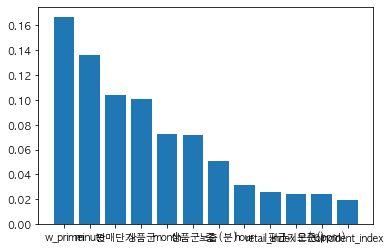

<Figure size 1440x2880 with 0 Axes>

In [124]:
plt.bar(columns[:12], feature_importance[:12])
plt.figure(figsize=(20, 40))
plt.show()
import warnings ; warnings.filterwarnings("ignore")

In [125]:
# select_features = columns[:5]
# select_features = [x for x in select_features]
# X = df[select_features]
# y = df['취급액']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
# model = XGBRegressor(objective='reg:squarederror')
# model.fit(X_train, y_train, eval_metric=['rmse','mae'])
# predictions = model.predict(X_test)
# print('mape: {}'.format(np.mean(np.abs((y_test-predictions)/y_test))))

features: 34, mape: 1.1447652295446022
features: 33, mape: 1.1447652295446022
features: 32, mape: 1.1447652295446022
features: 31, mape: 1.1447652295446022
features: 30, mape: 1.1447652295446022
features: 29, mape: 1.1447652295446022
features: 28, mape: 1.1447652295446022
features: 27, mape: 1.1447652295446022
features: 26, mape: 1.144899456382794
features: 25, mape: 1.1447059562485746
features: 24, mape: 1.1448946500567958
features: 23, mape: 1.1449906723982186
features: 22, mape: 1.1419983608764552
features: 21, mape: 1.1435467208329693
features: 20, mape: 1.129690463862252
features: 19, mape: 1.1501279030696843
features: 18, mape: 1.149912188305634
features: 17, mape: 1.149912188305634
features: 16, mape: 1.1262493488392582
features: 15, mape: 1.126502668404989
features: 14, mape: 1.1253591002872942
features: 13, mape: 1.1472917438395578
features: 12, mape: 1.1278321750246034
features: 11, mape: 1.1209751983128535
features: 10, mape: 1.1236301701699196
features: 9, mape: 1.114769242

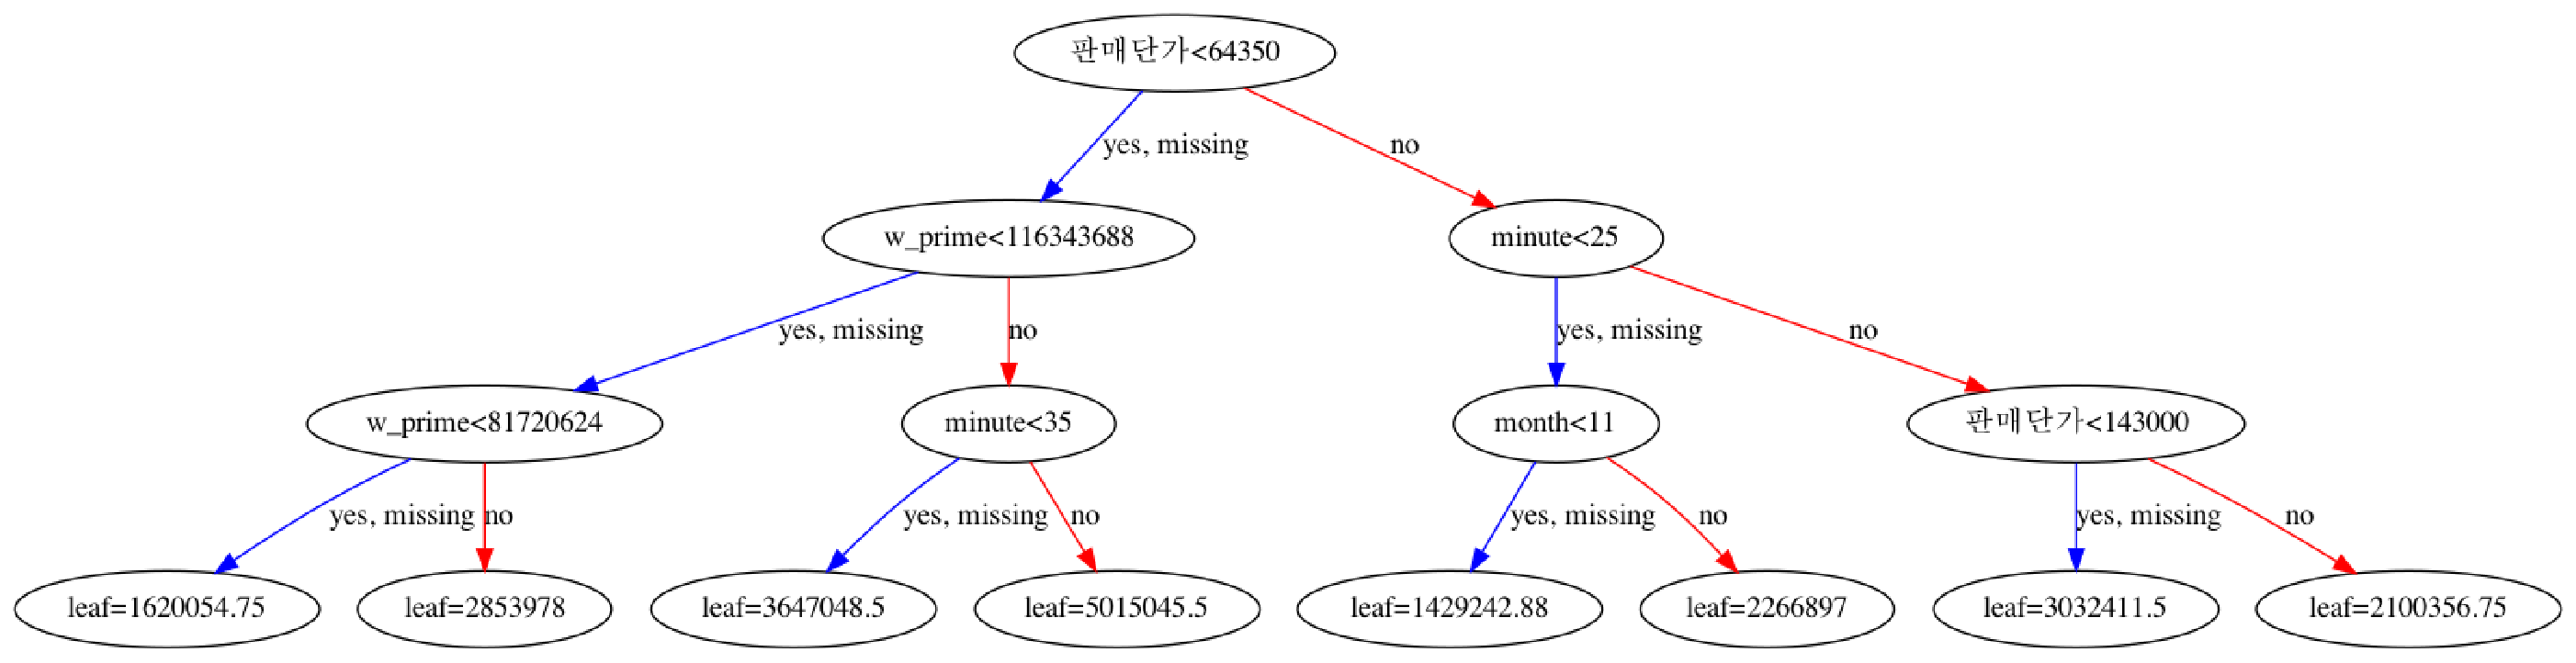

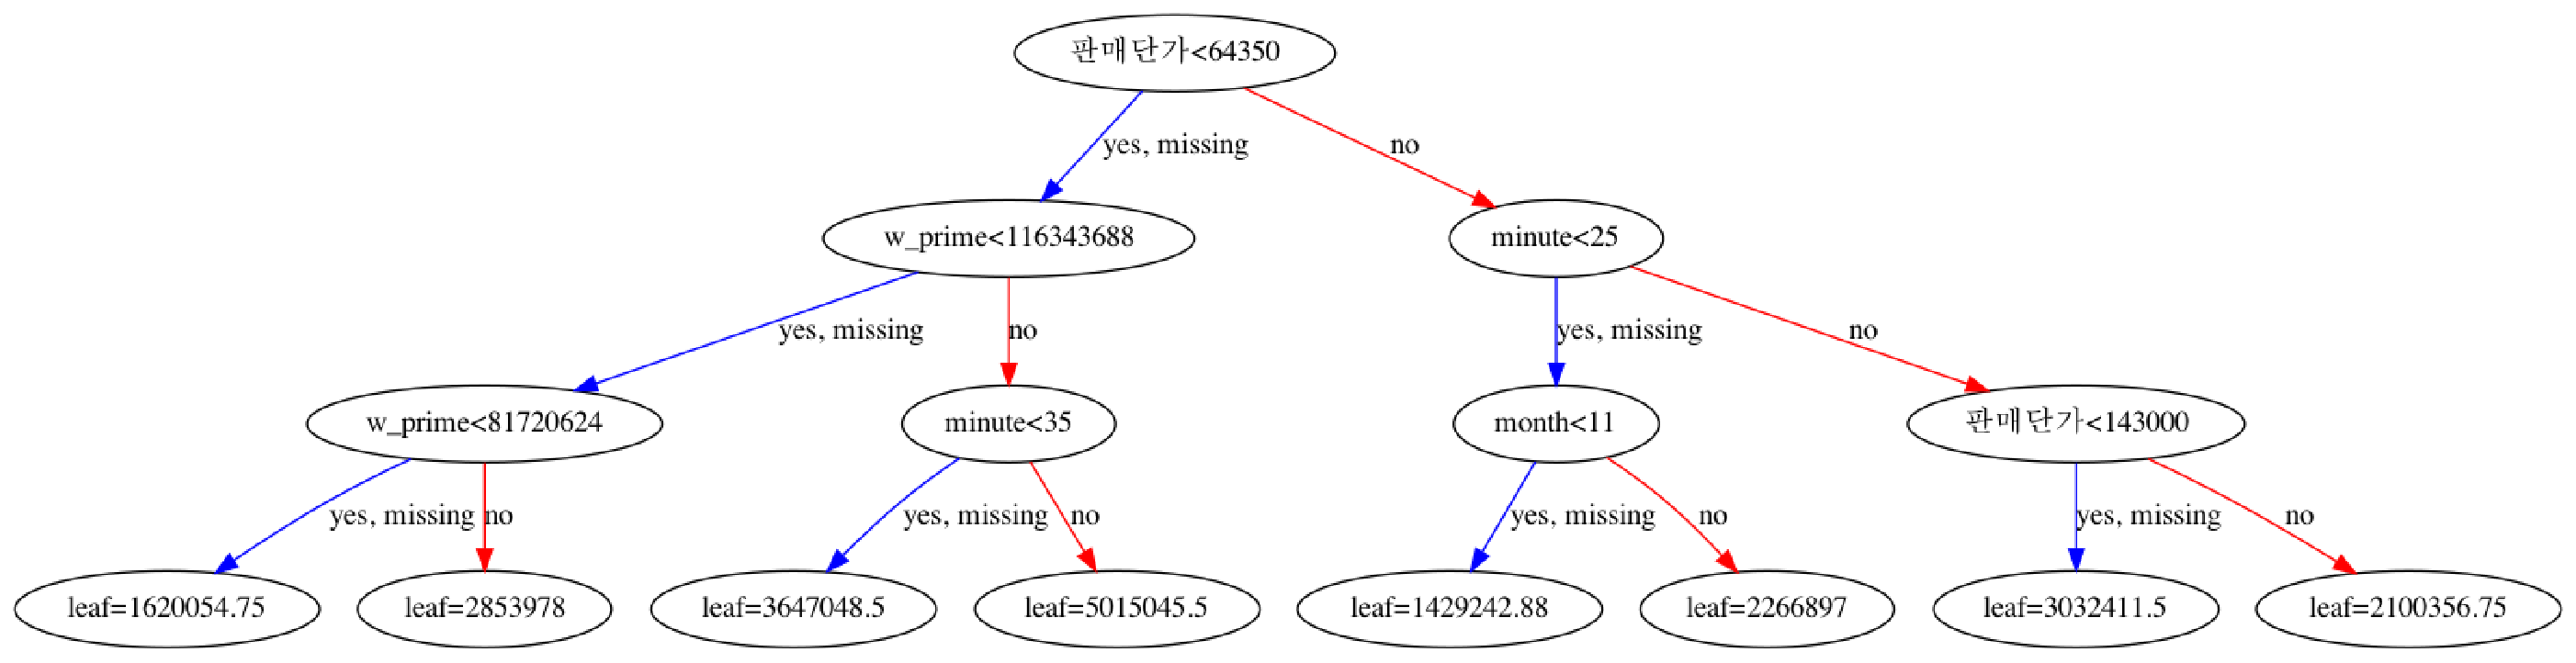

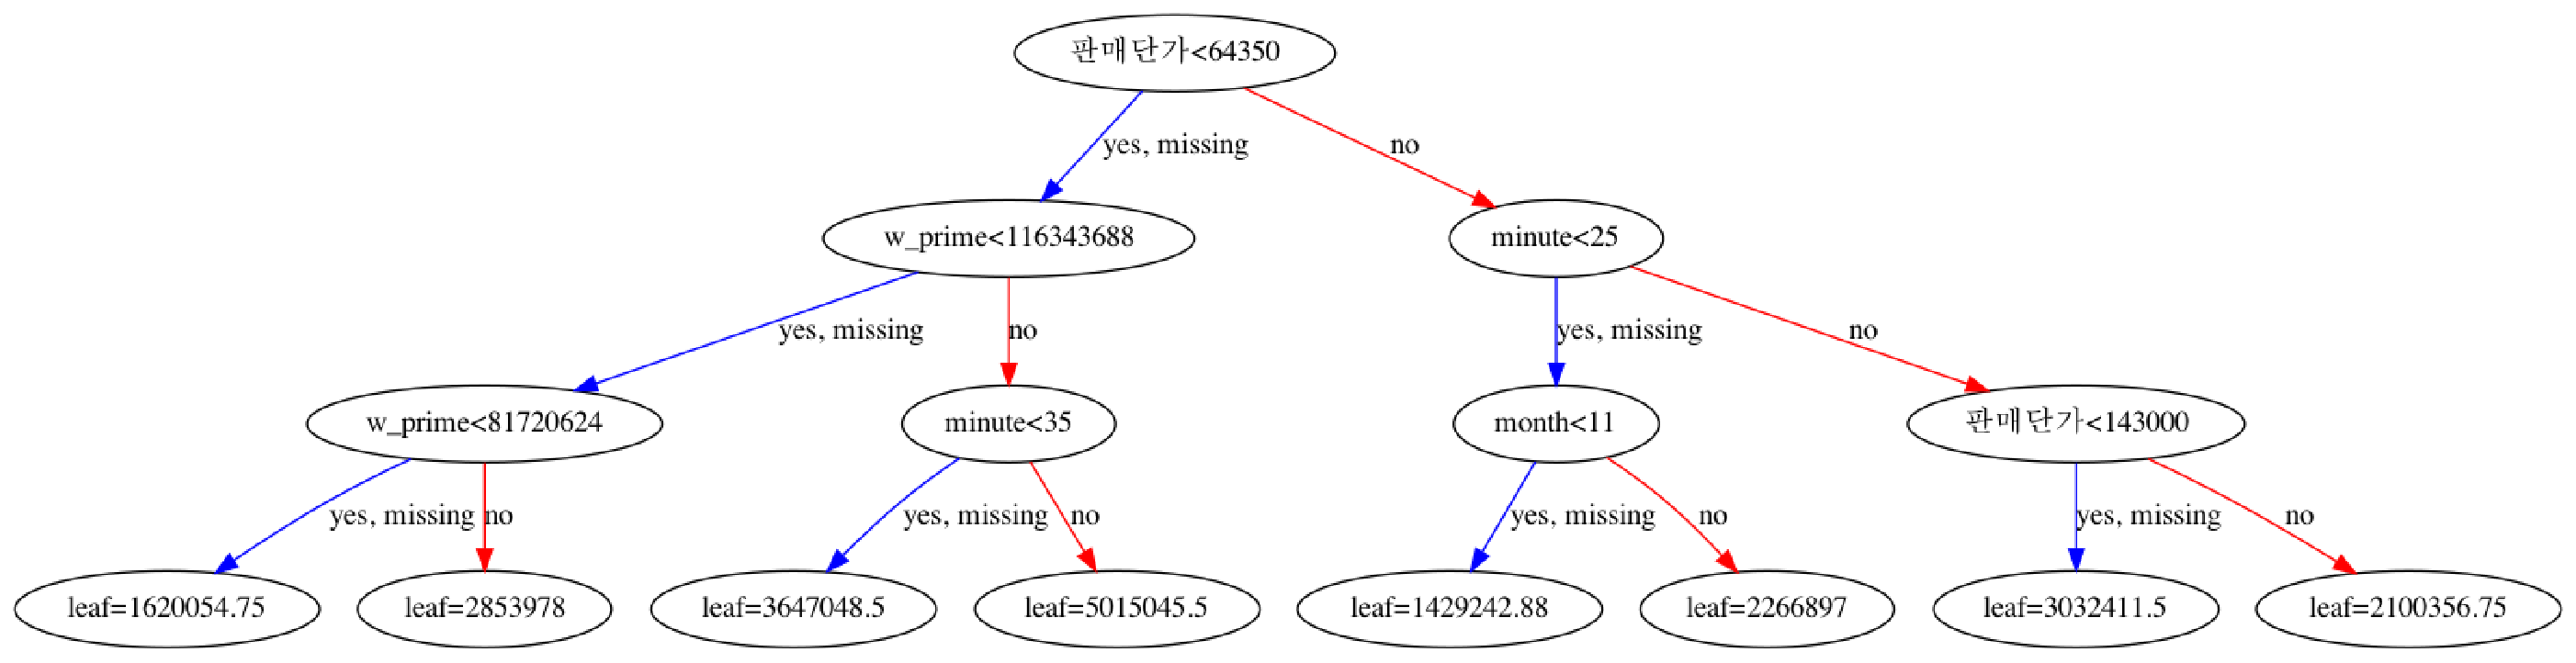

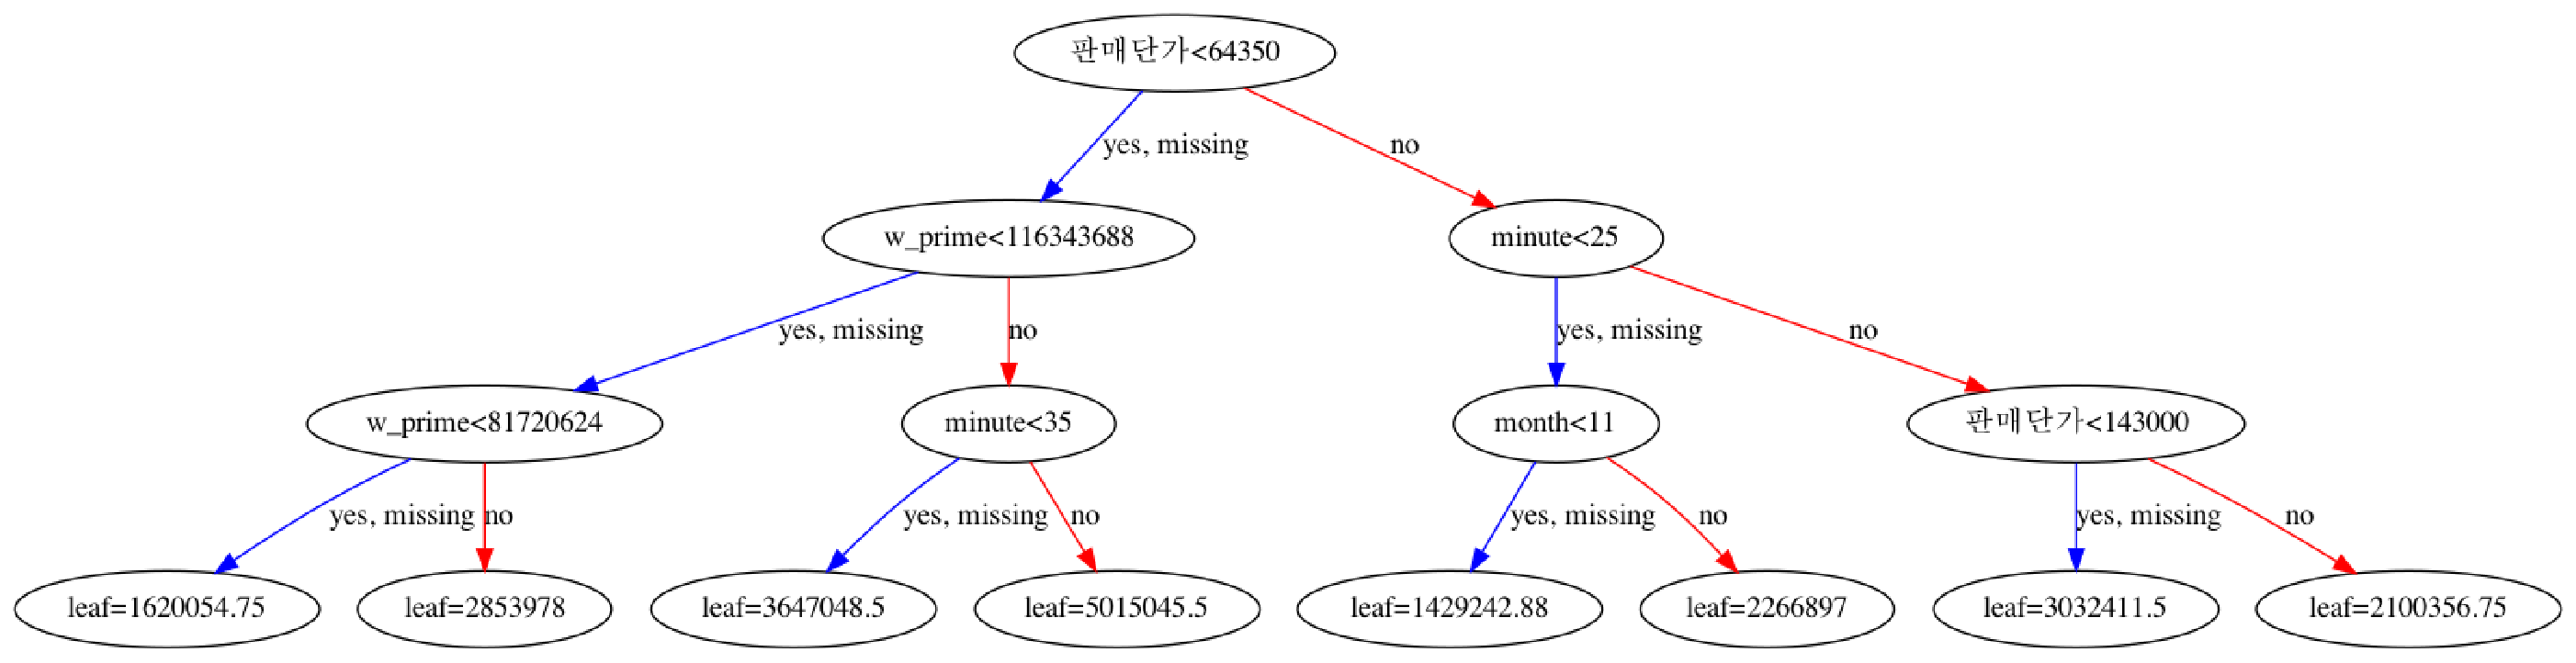

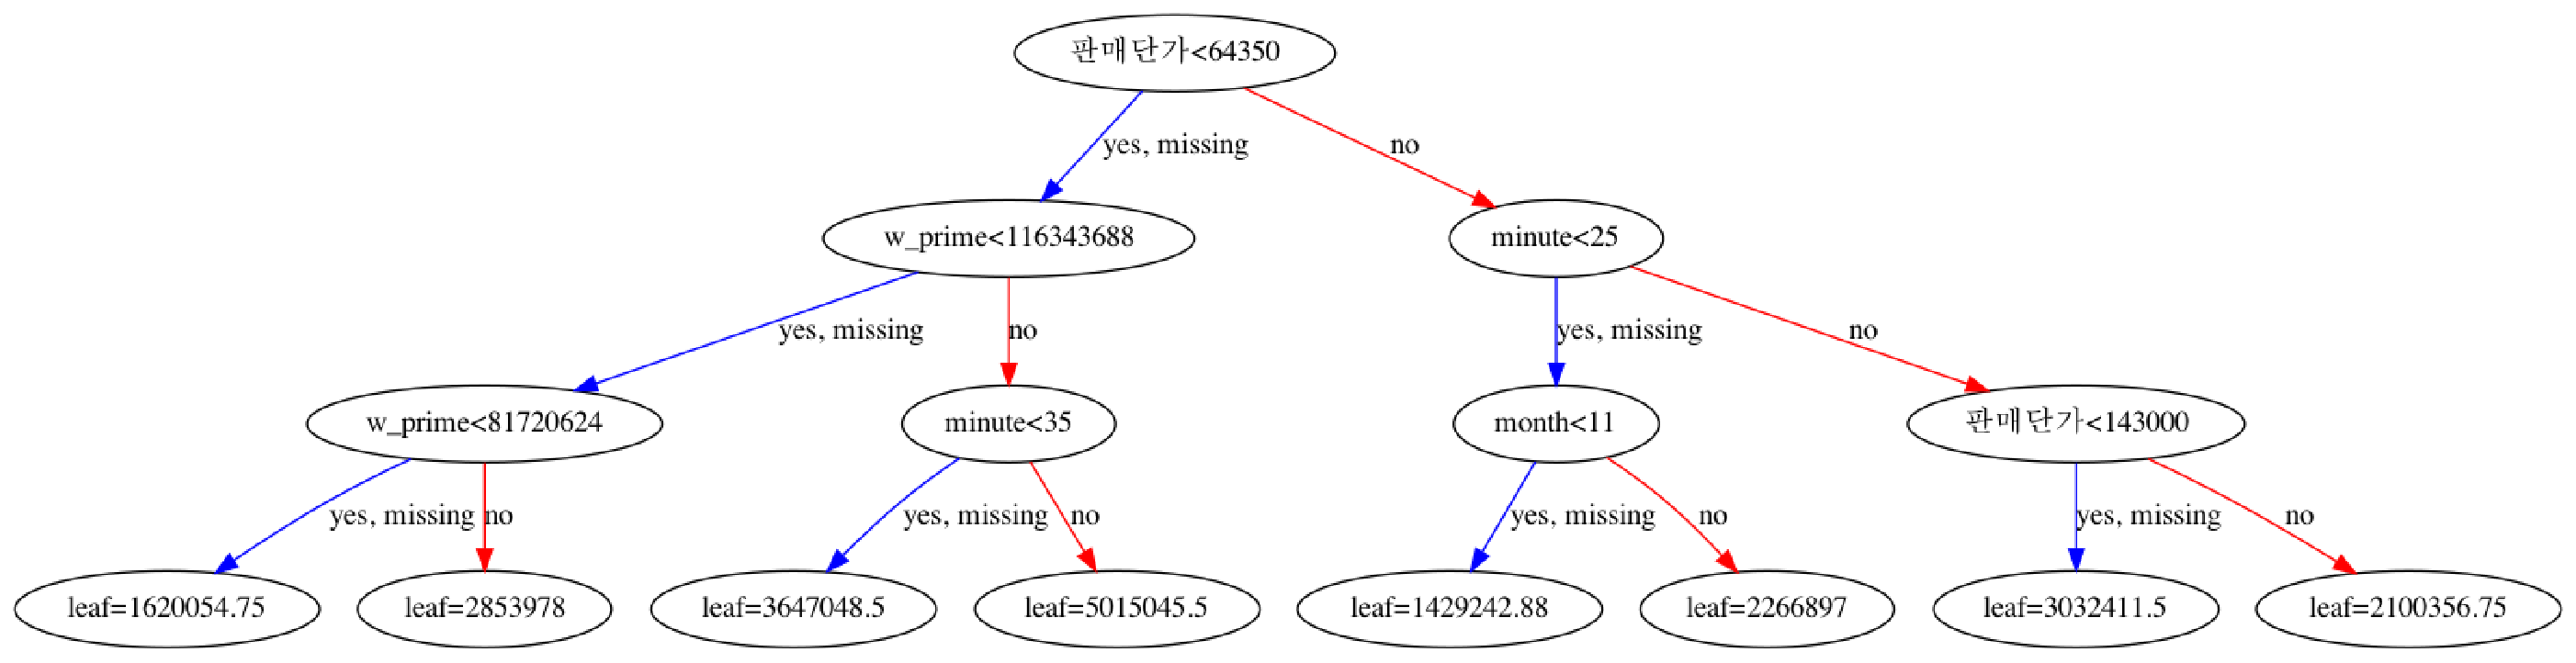

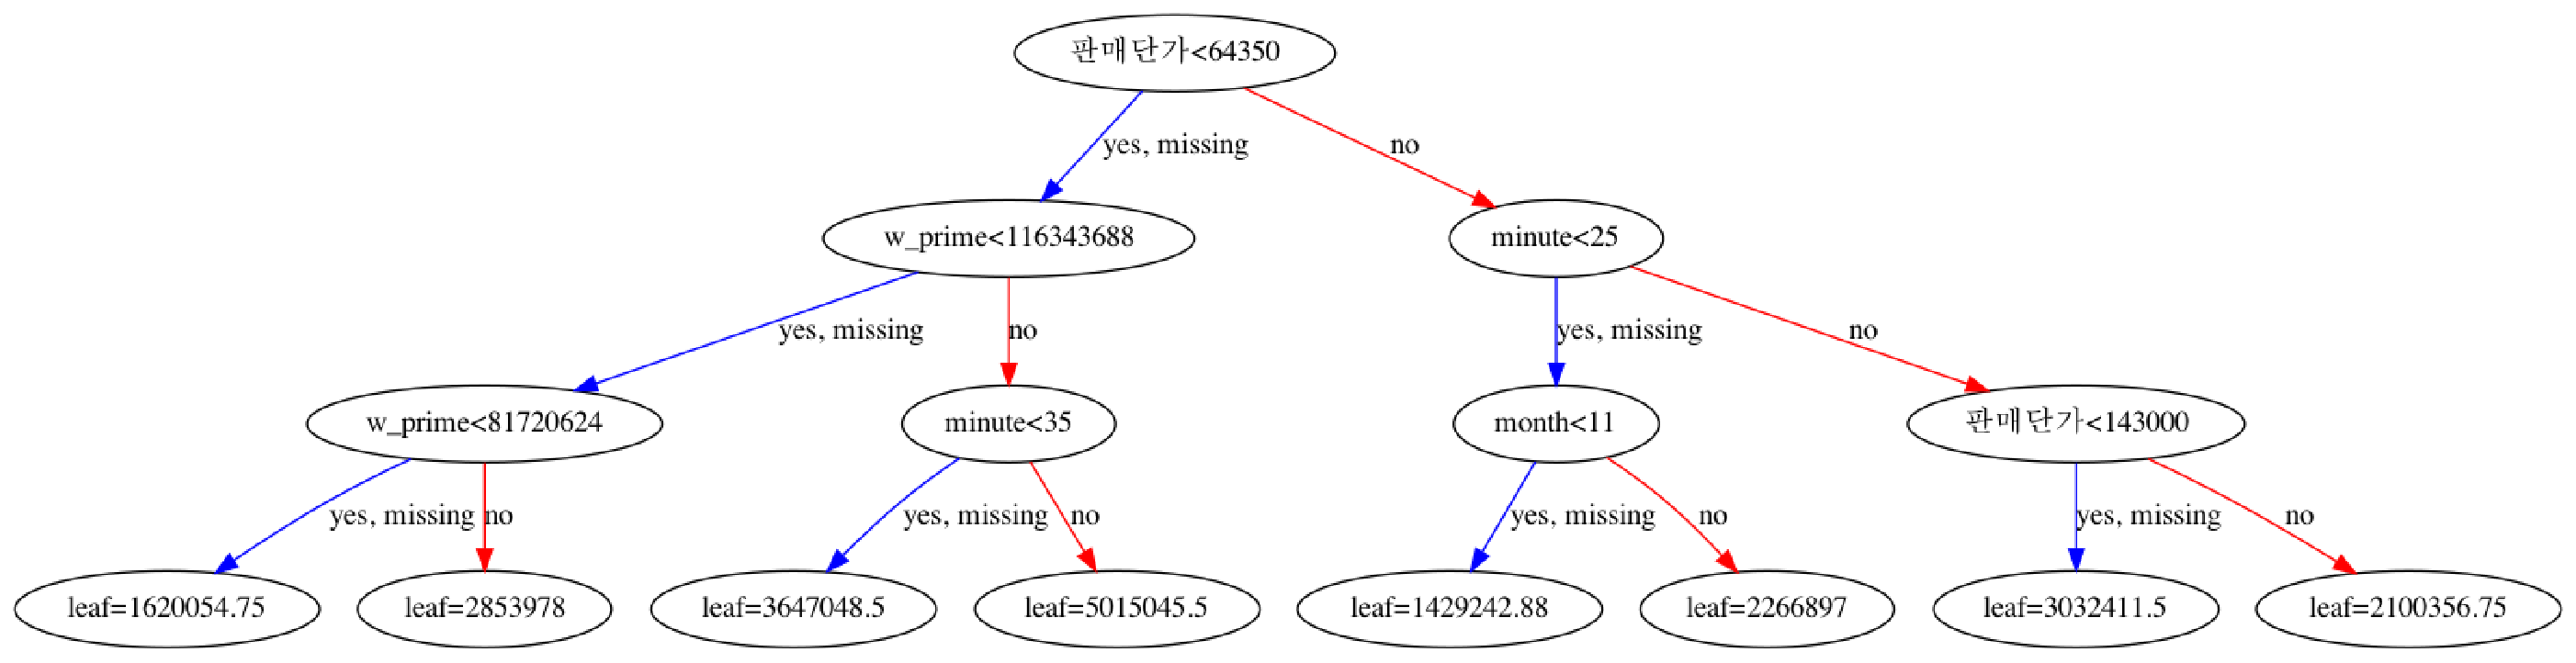

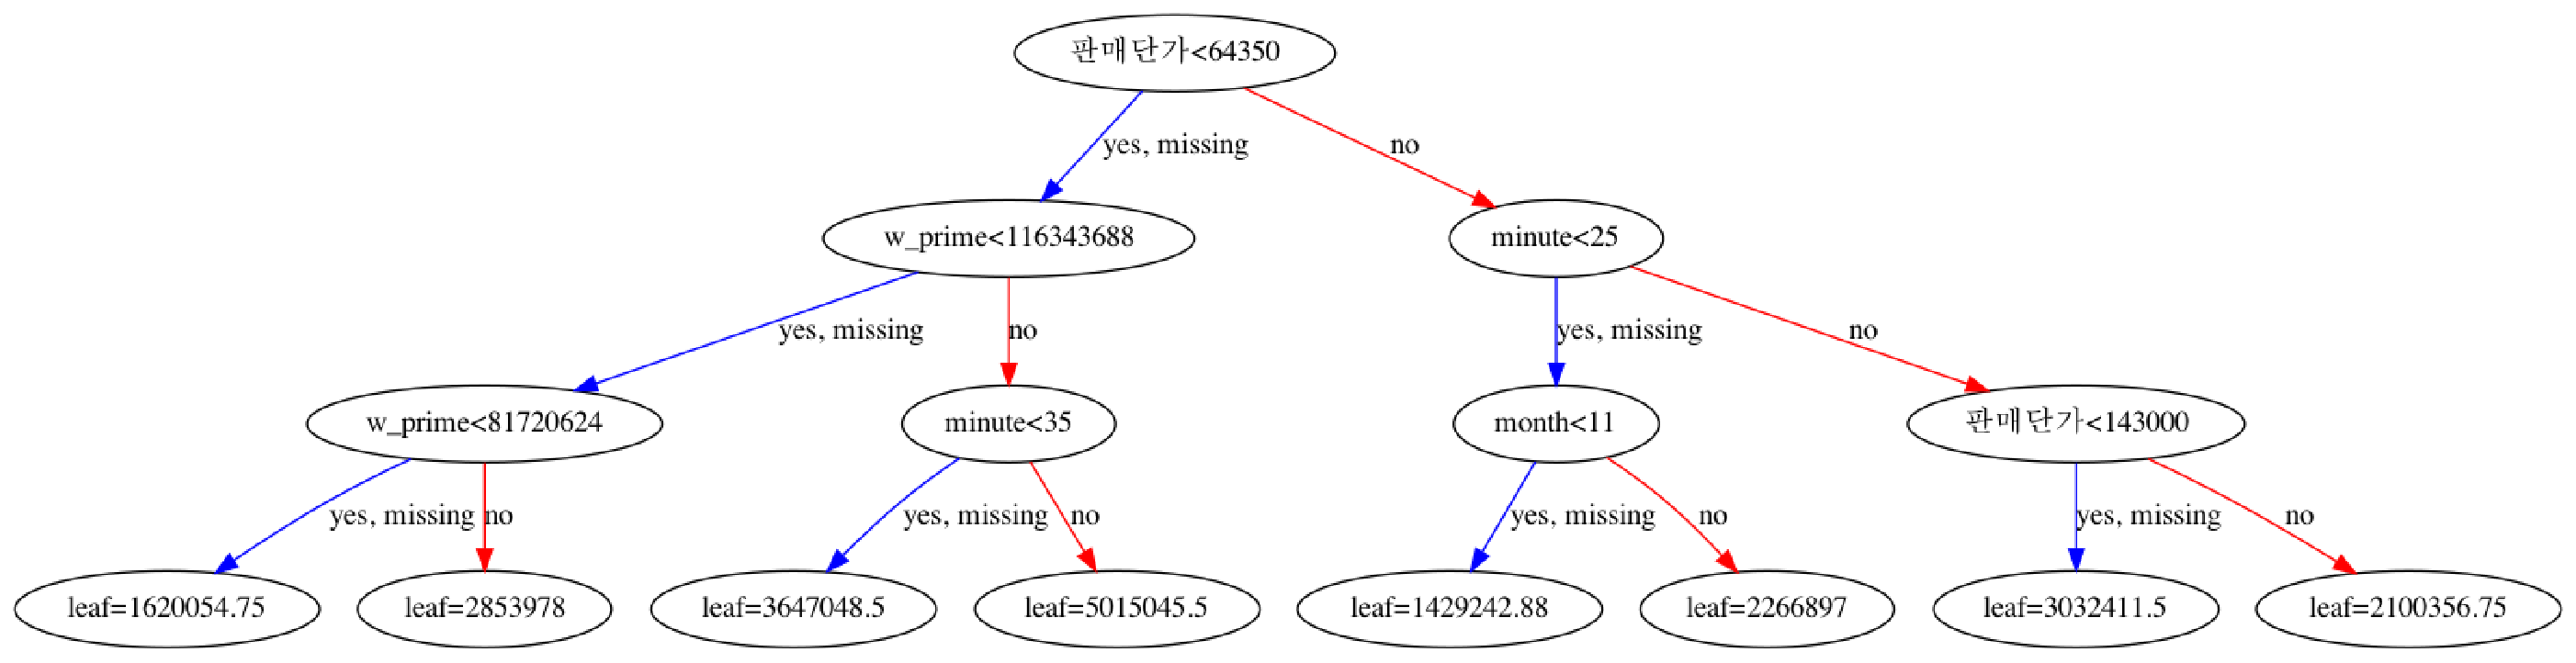

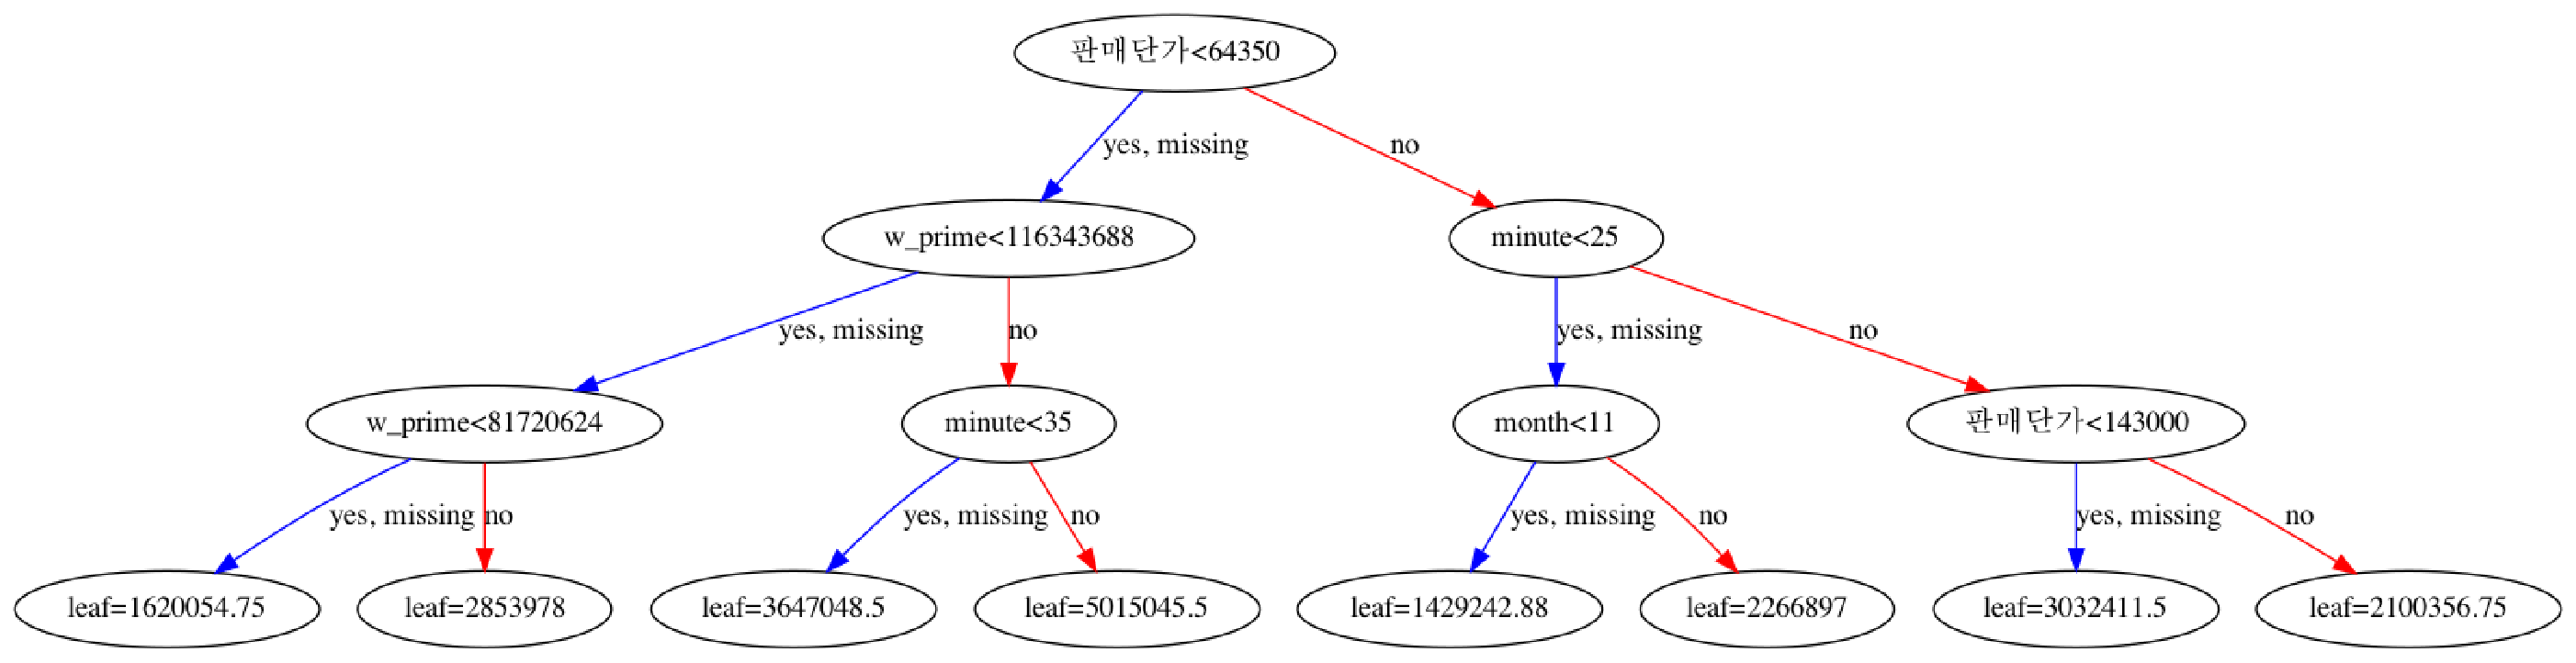

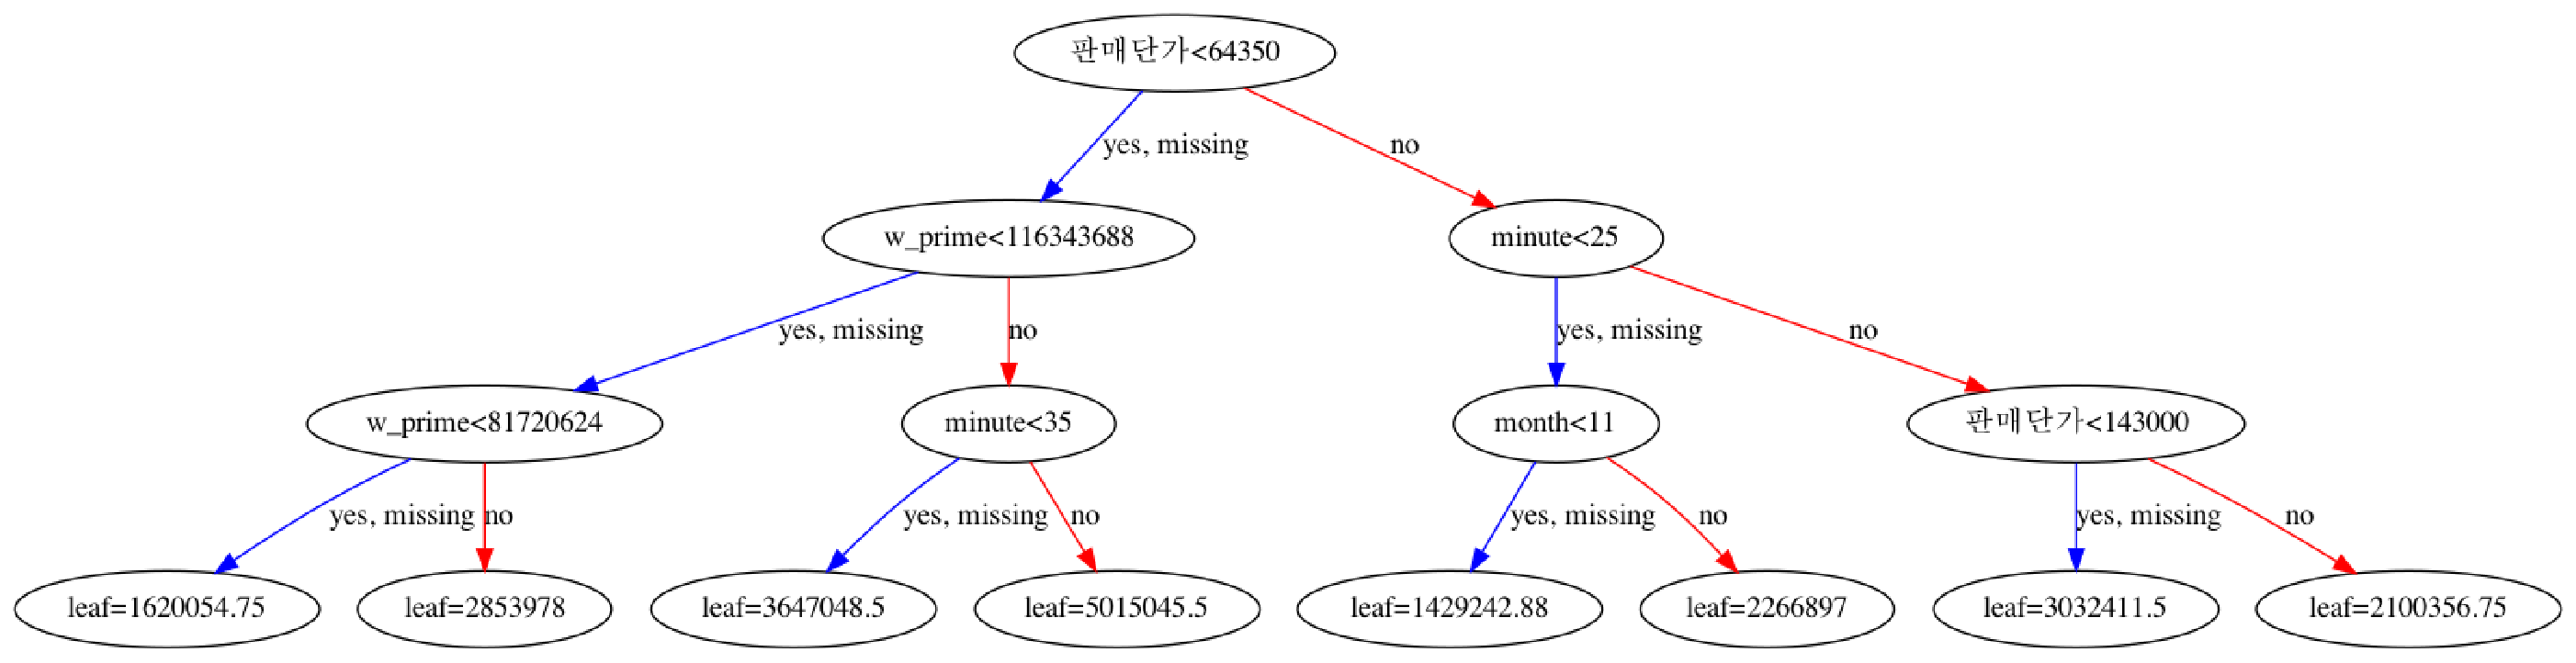

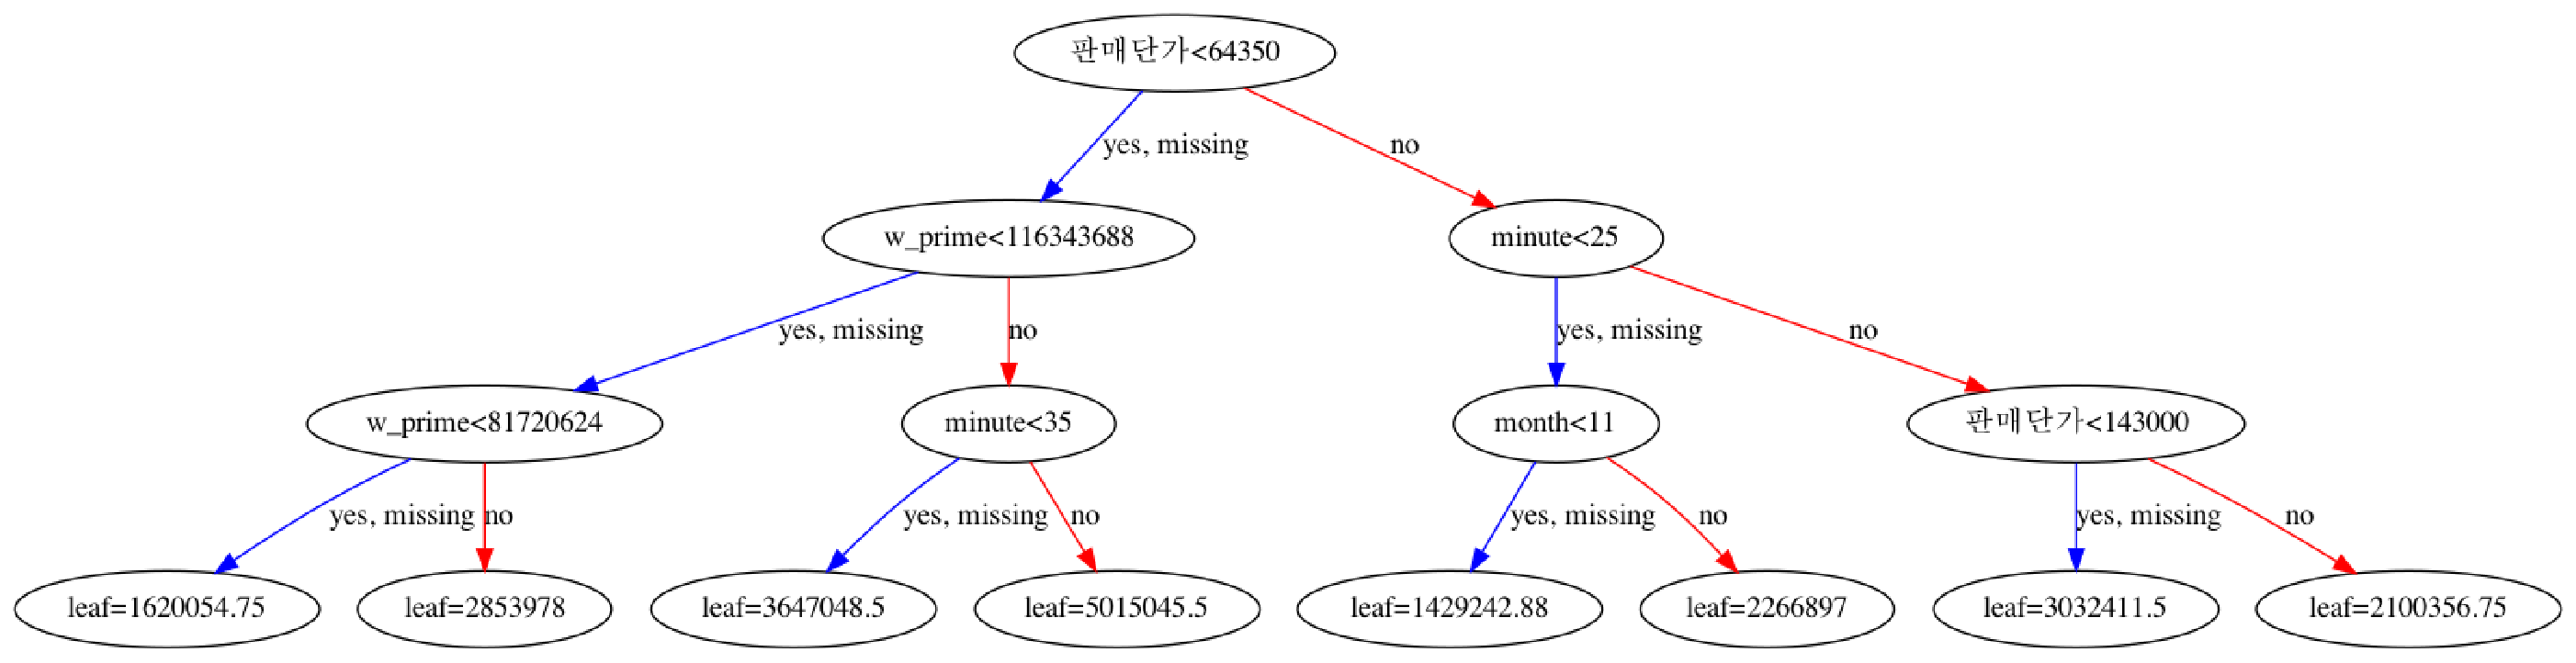

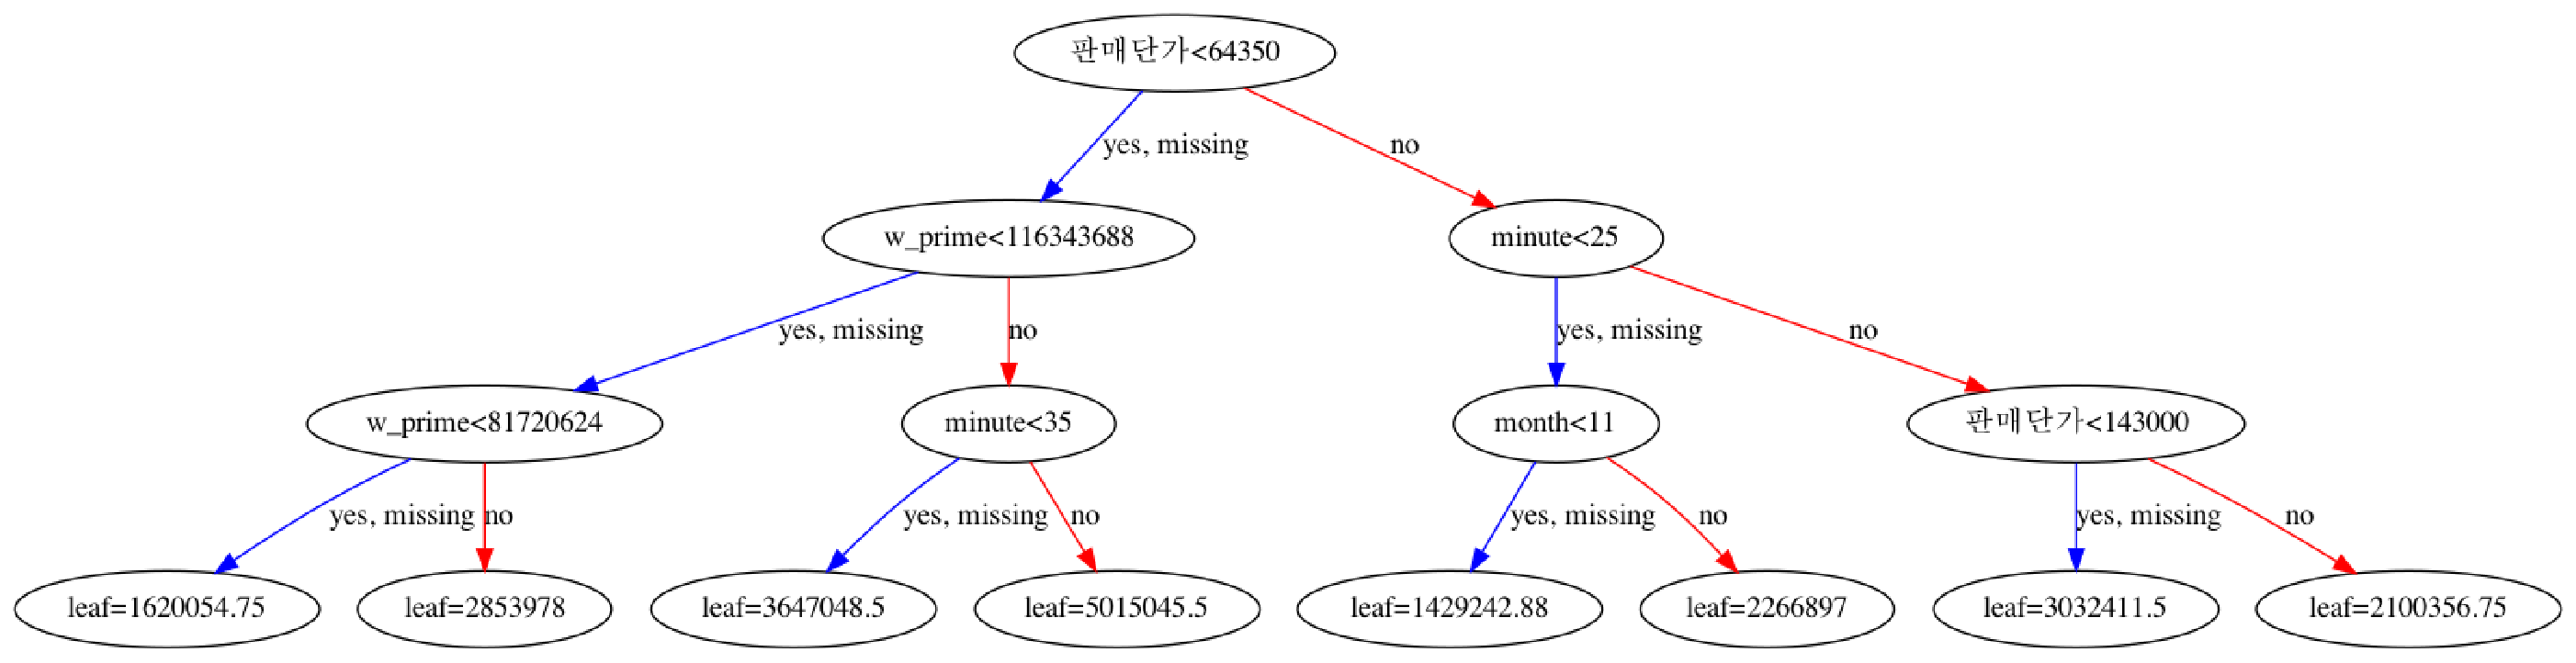

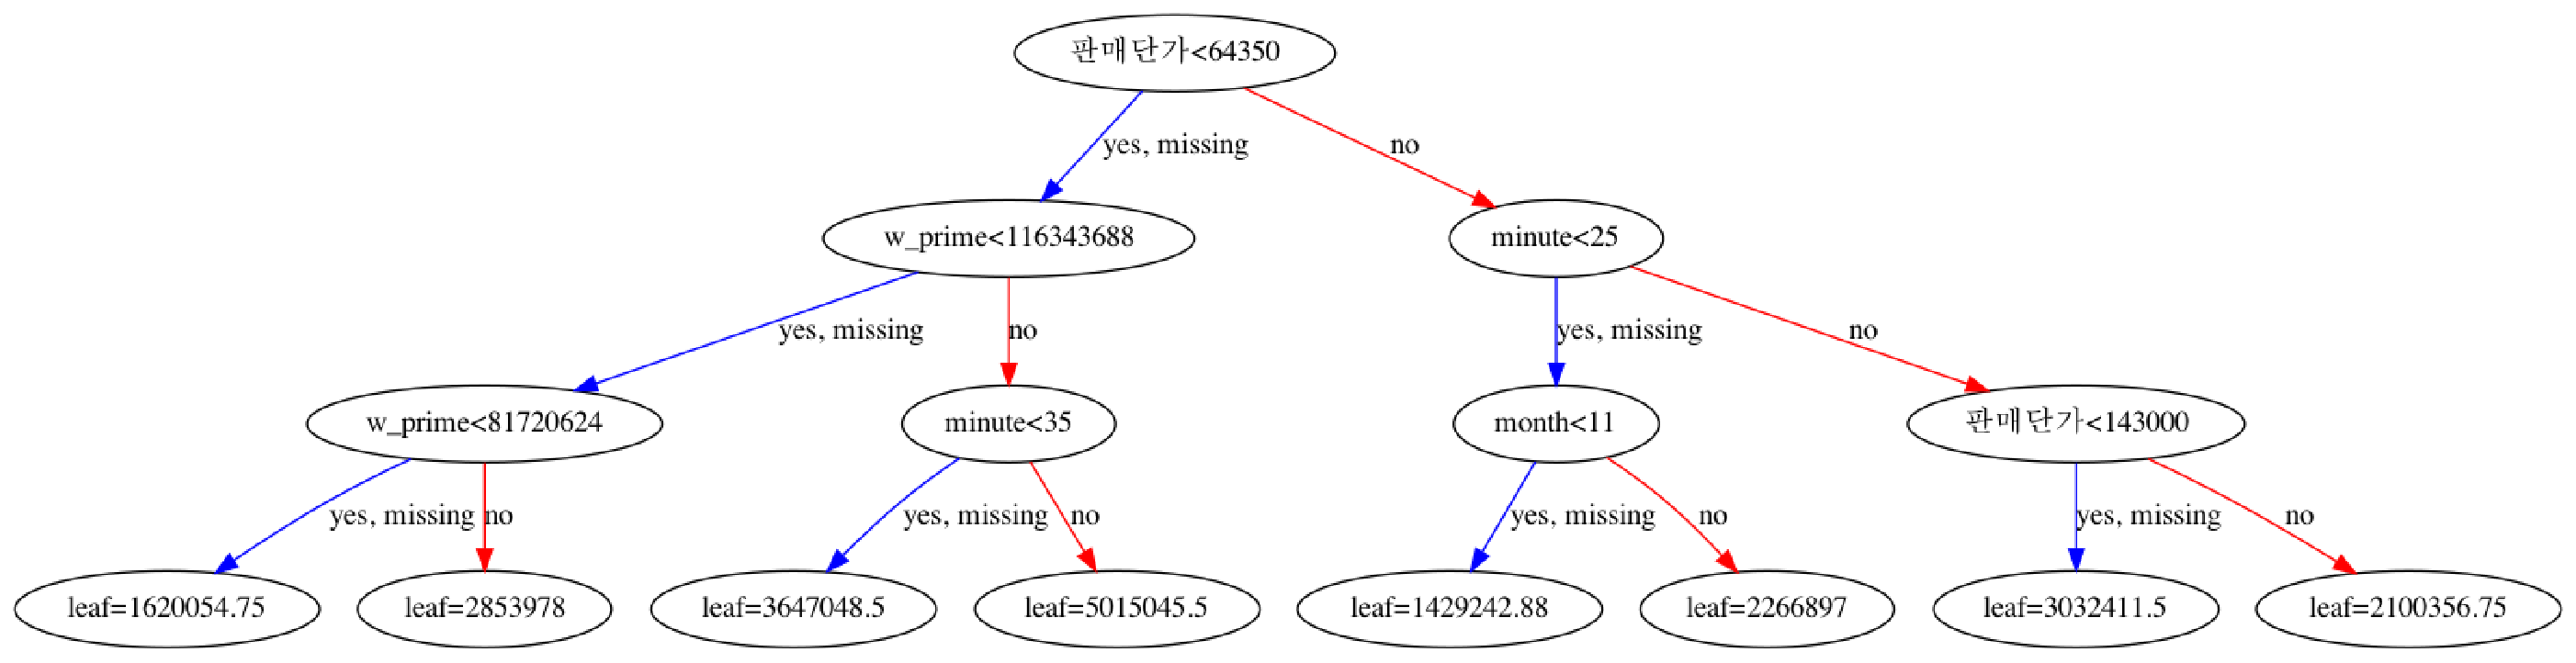

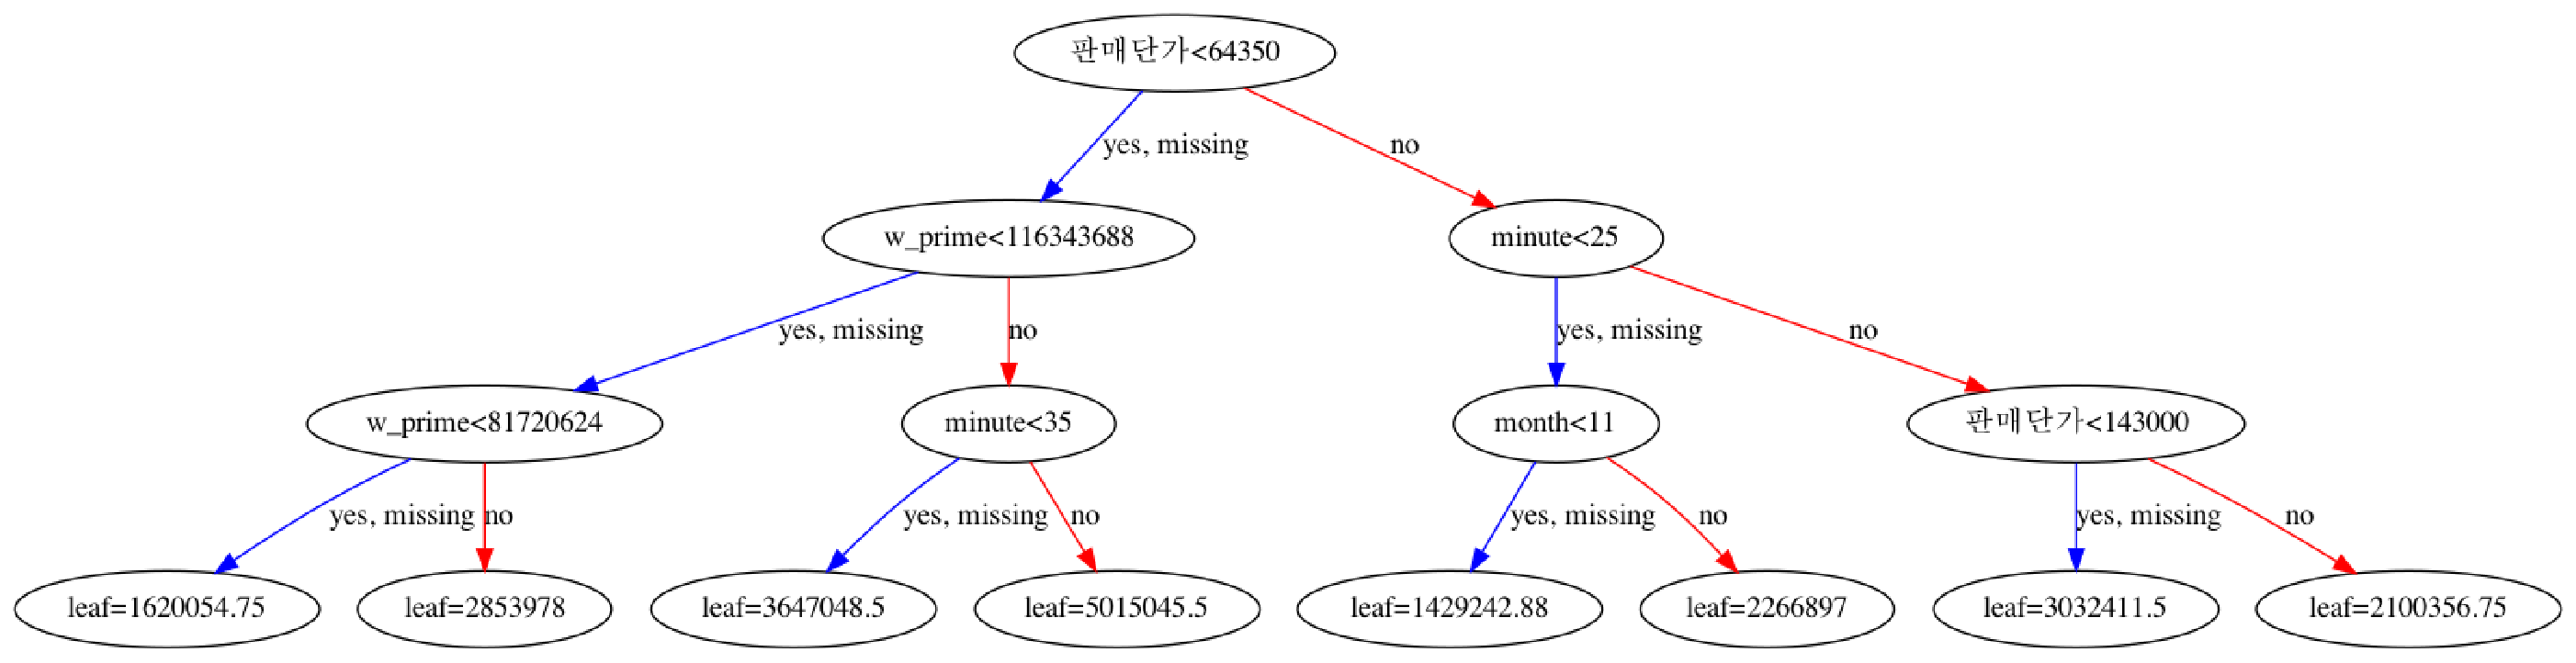

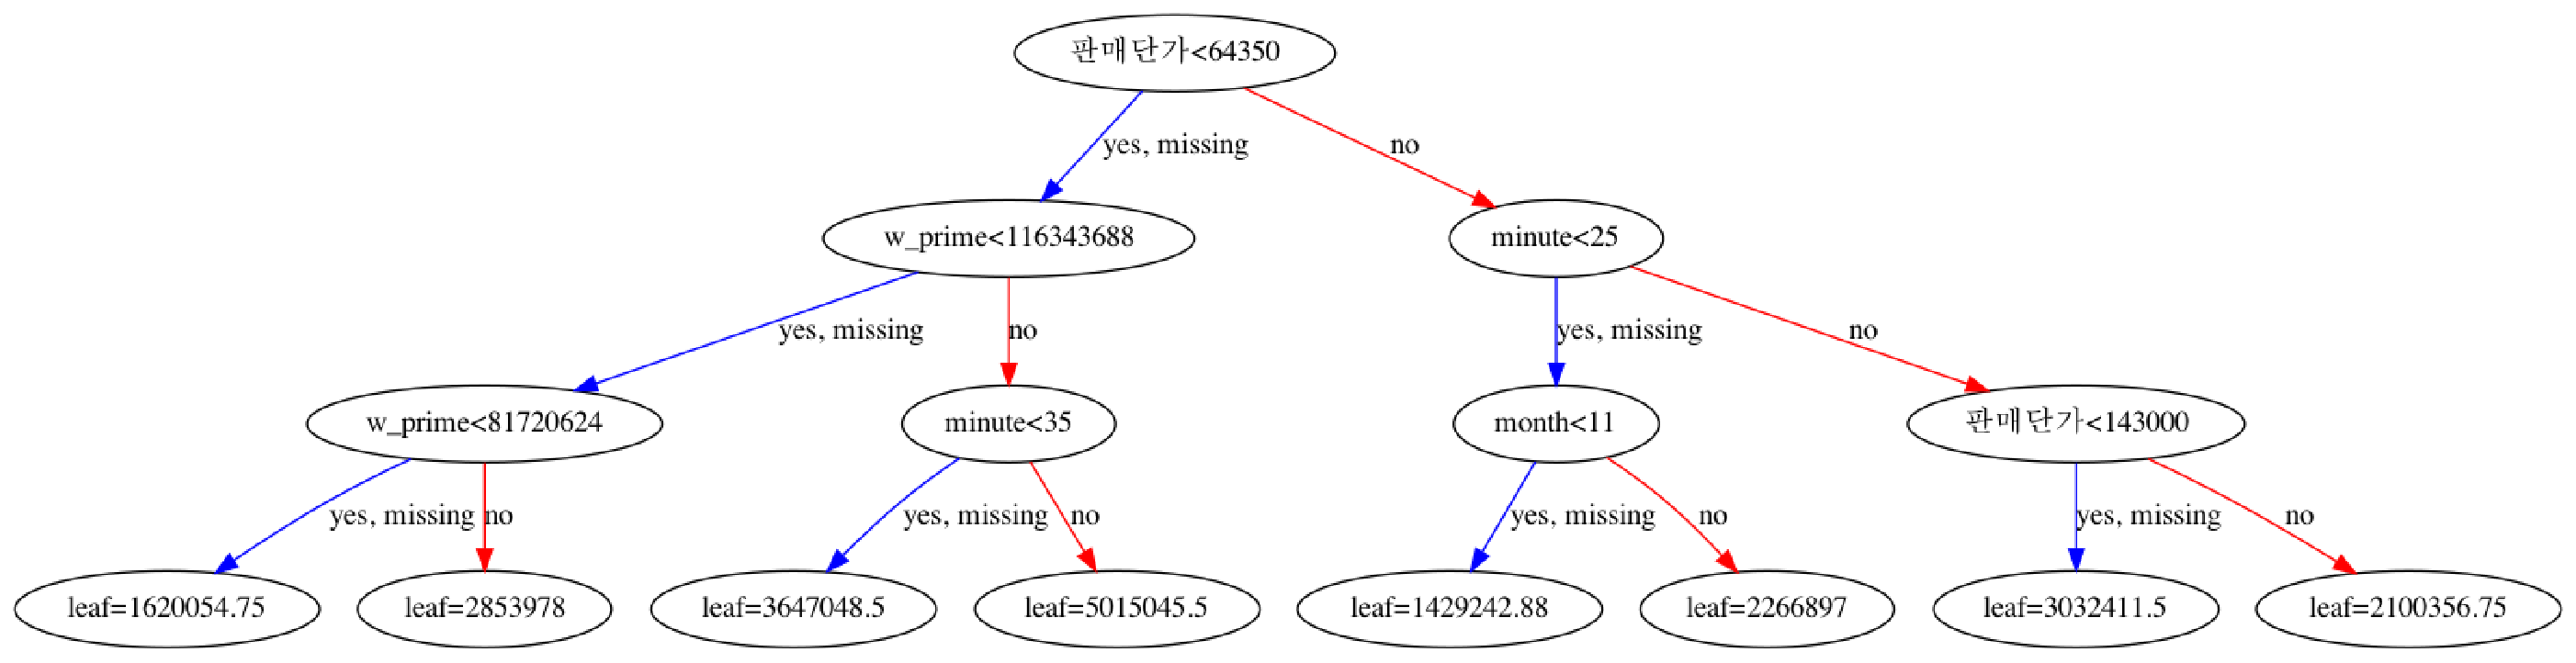

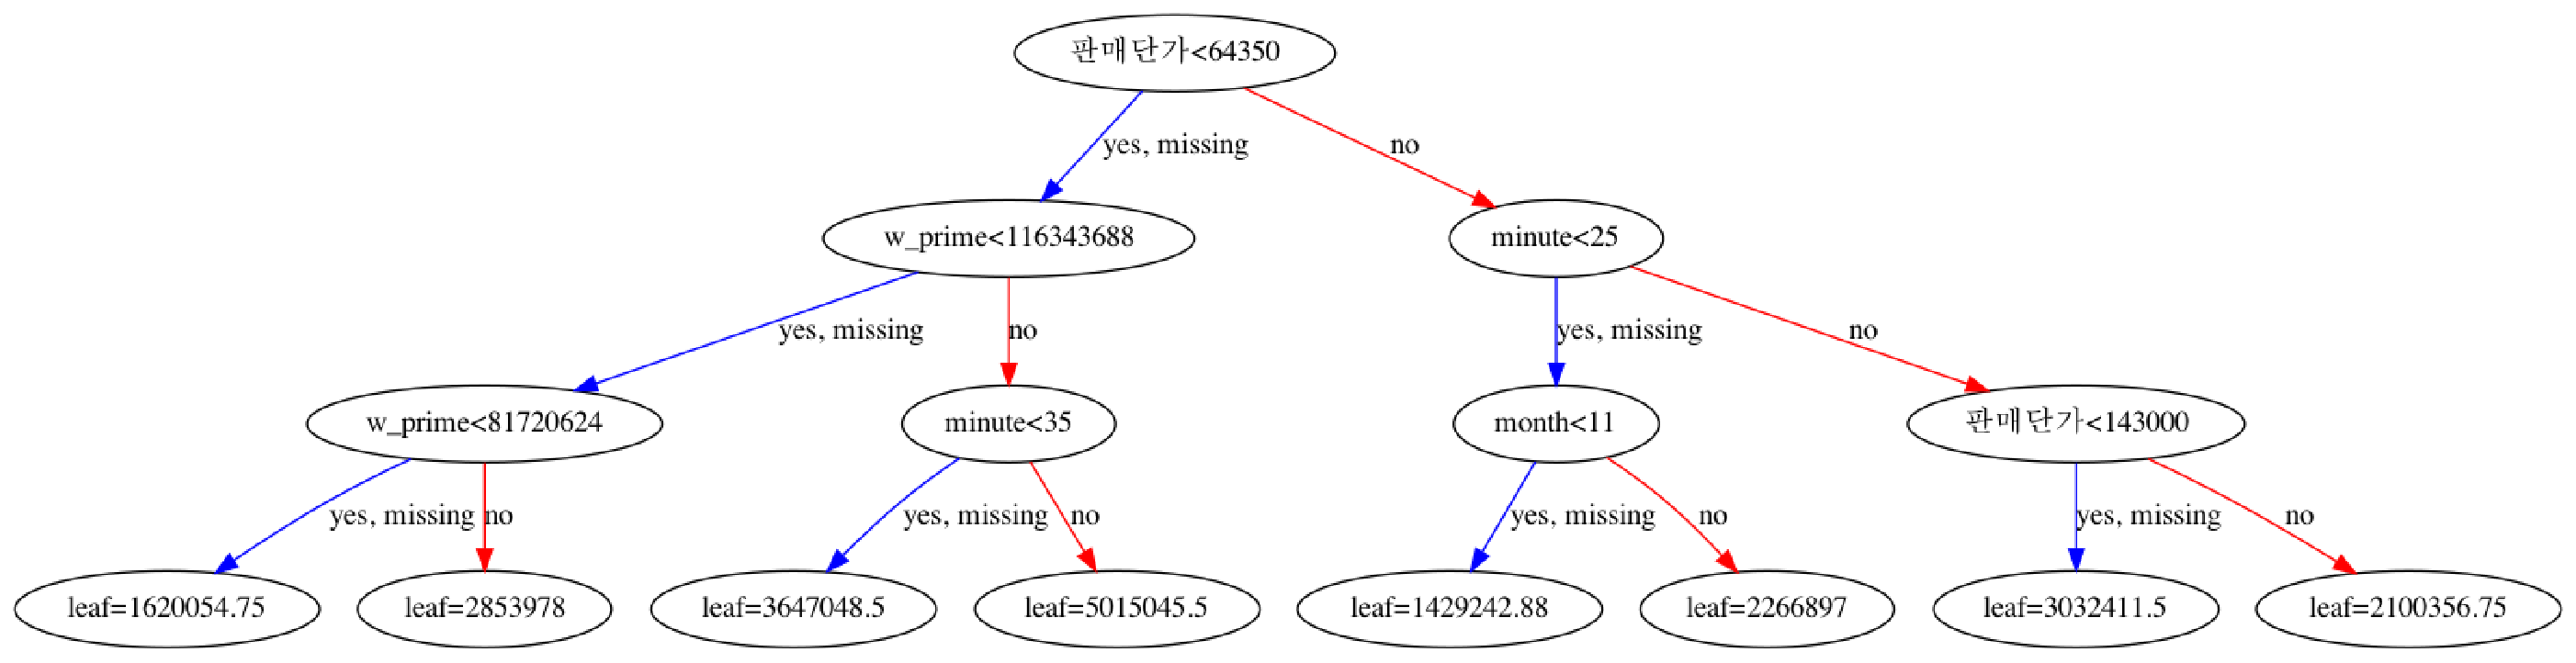

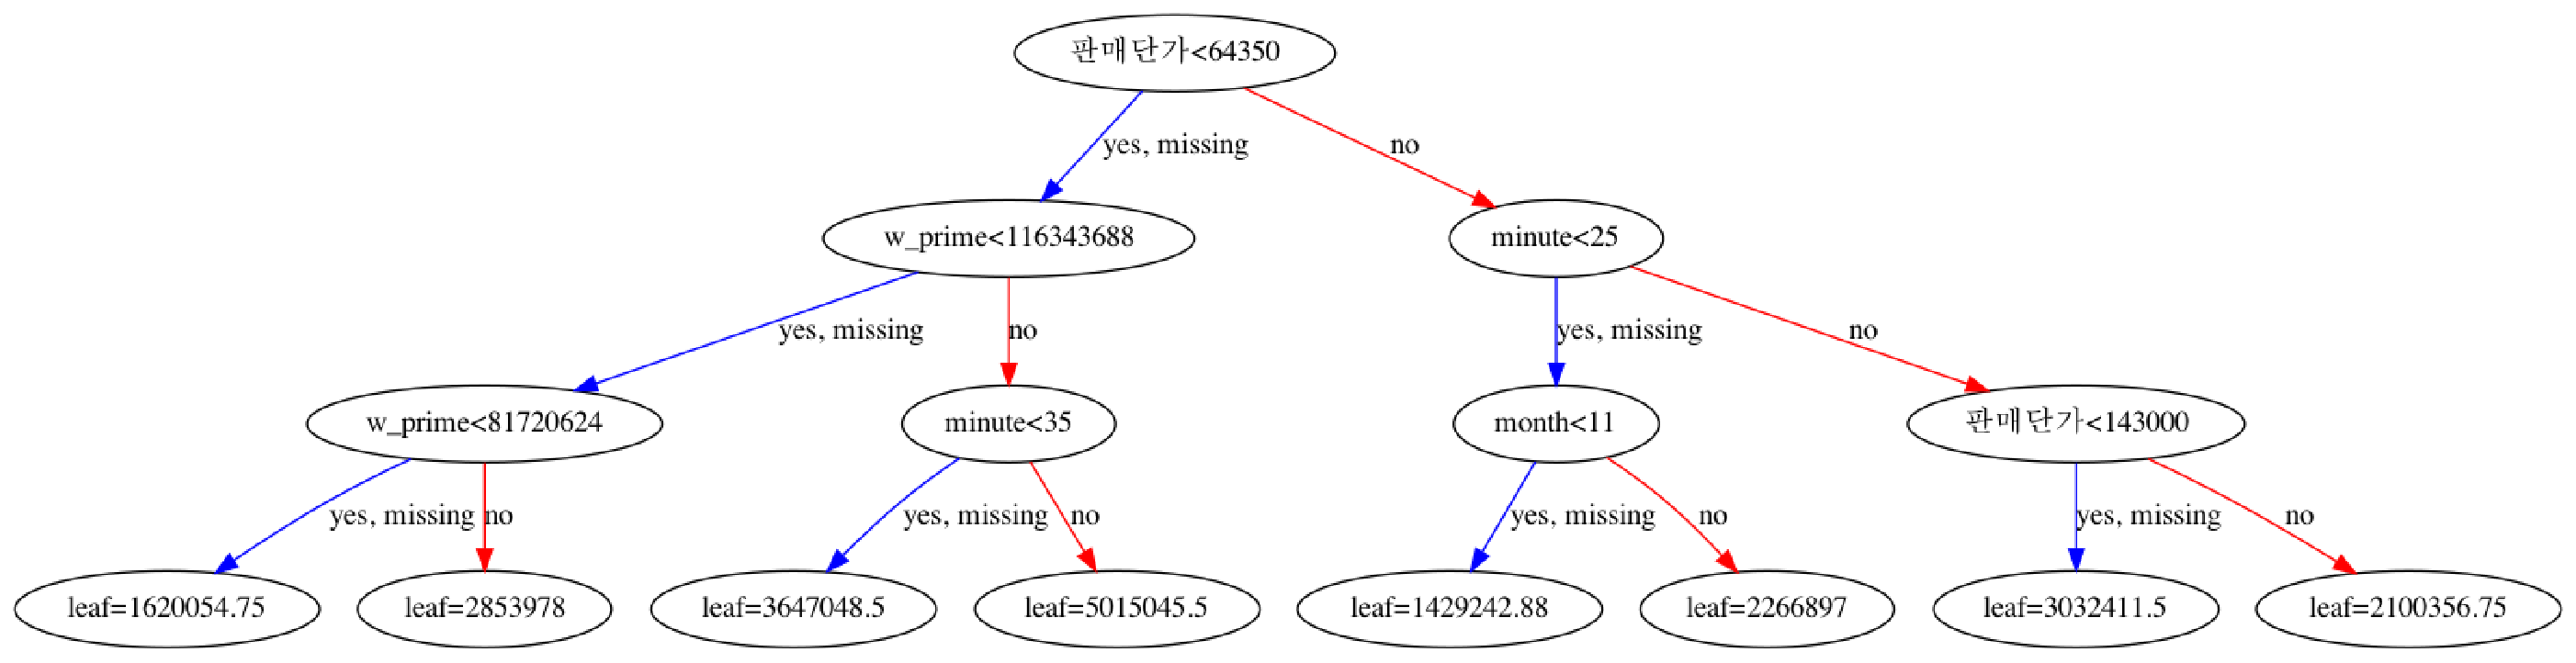

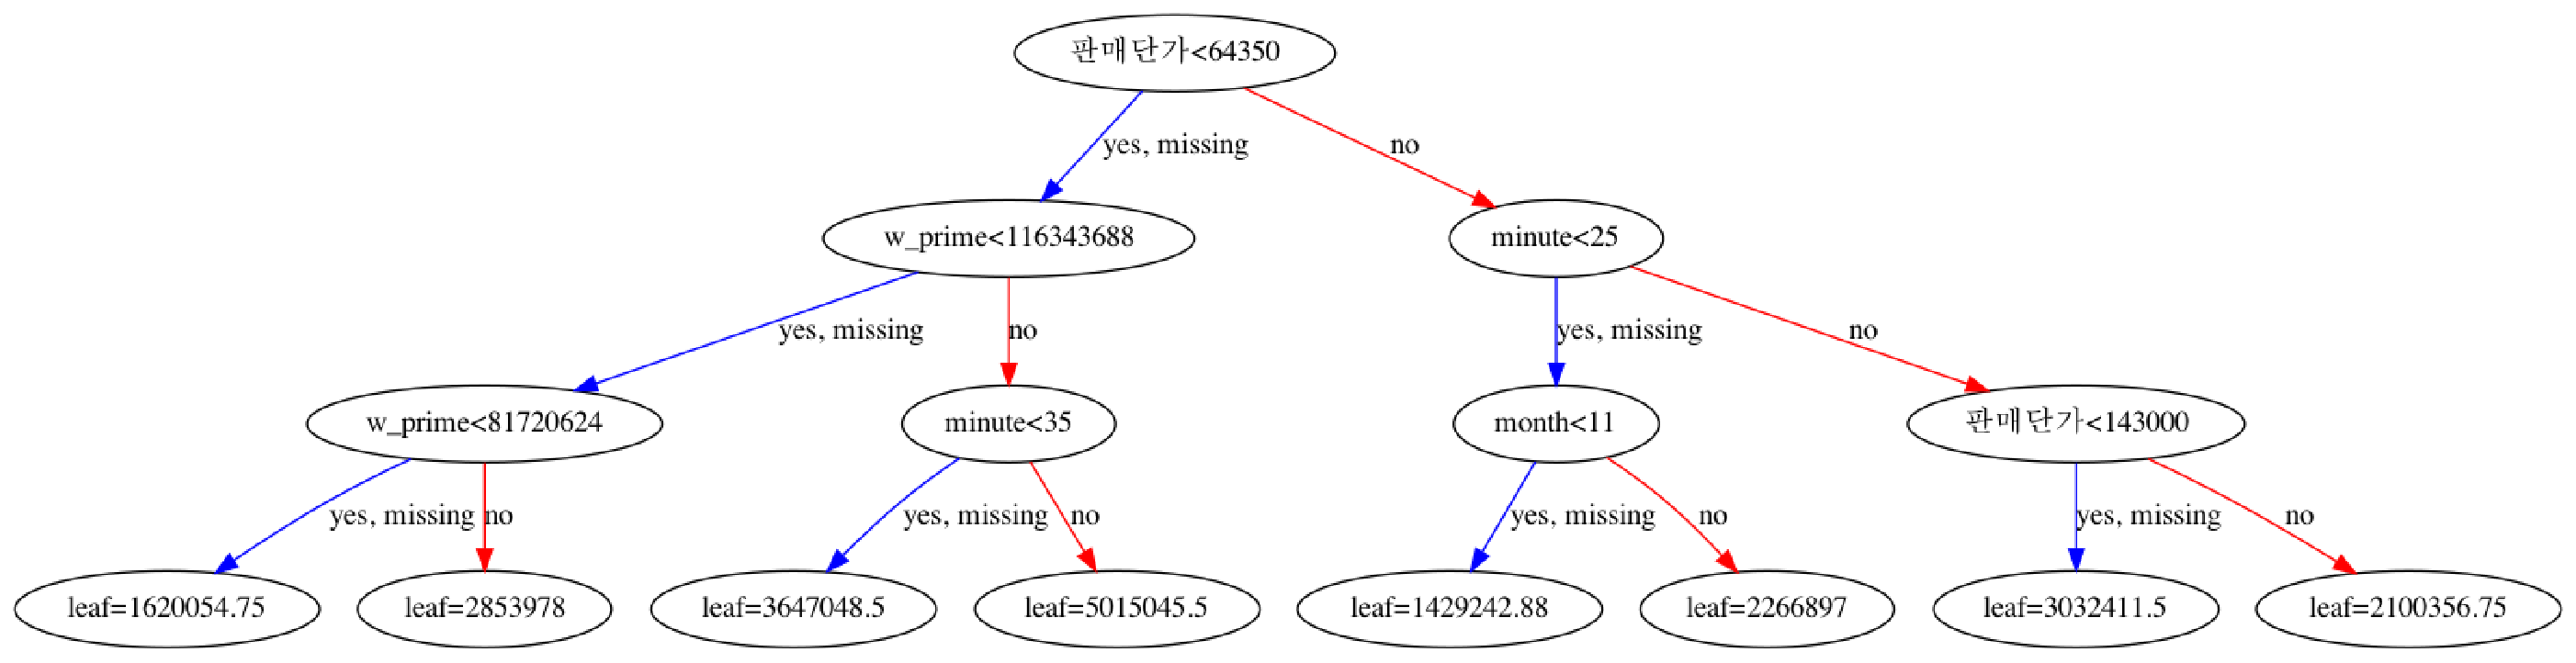

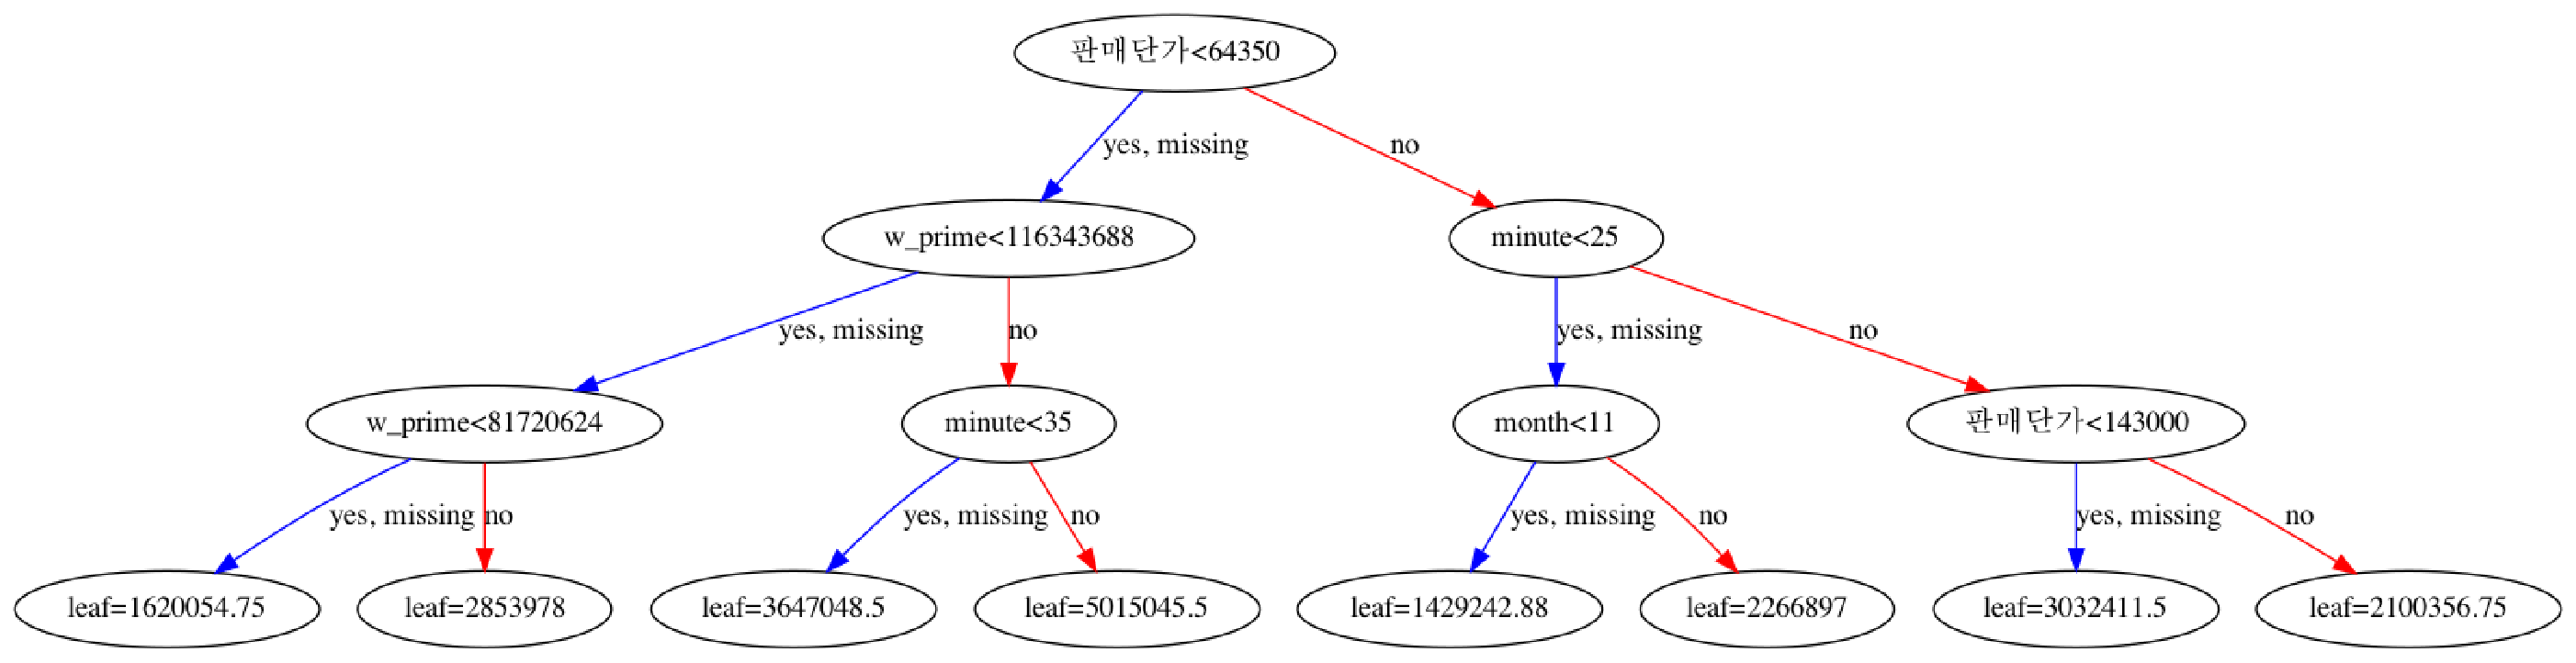

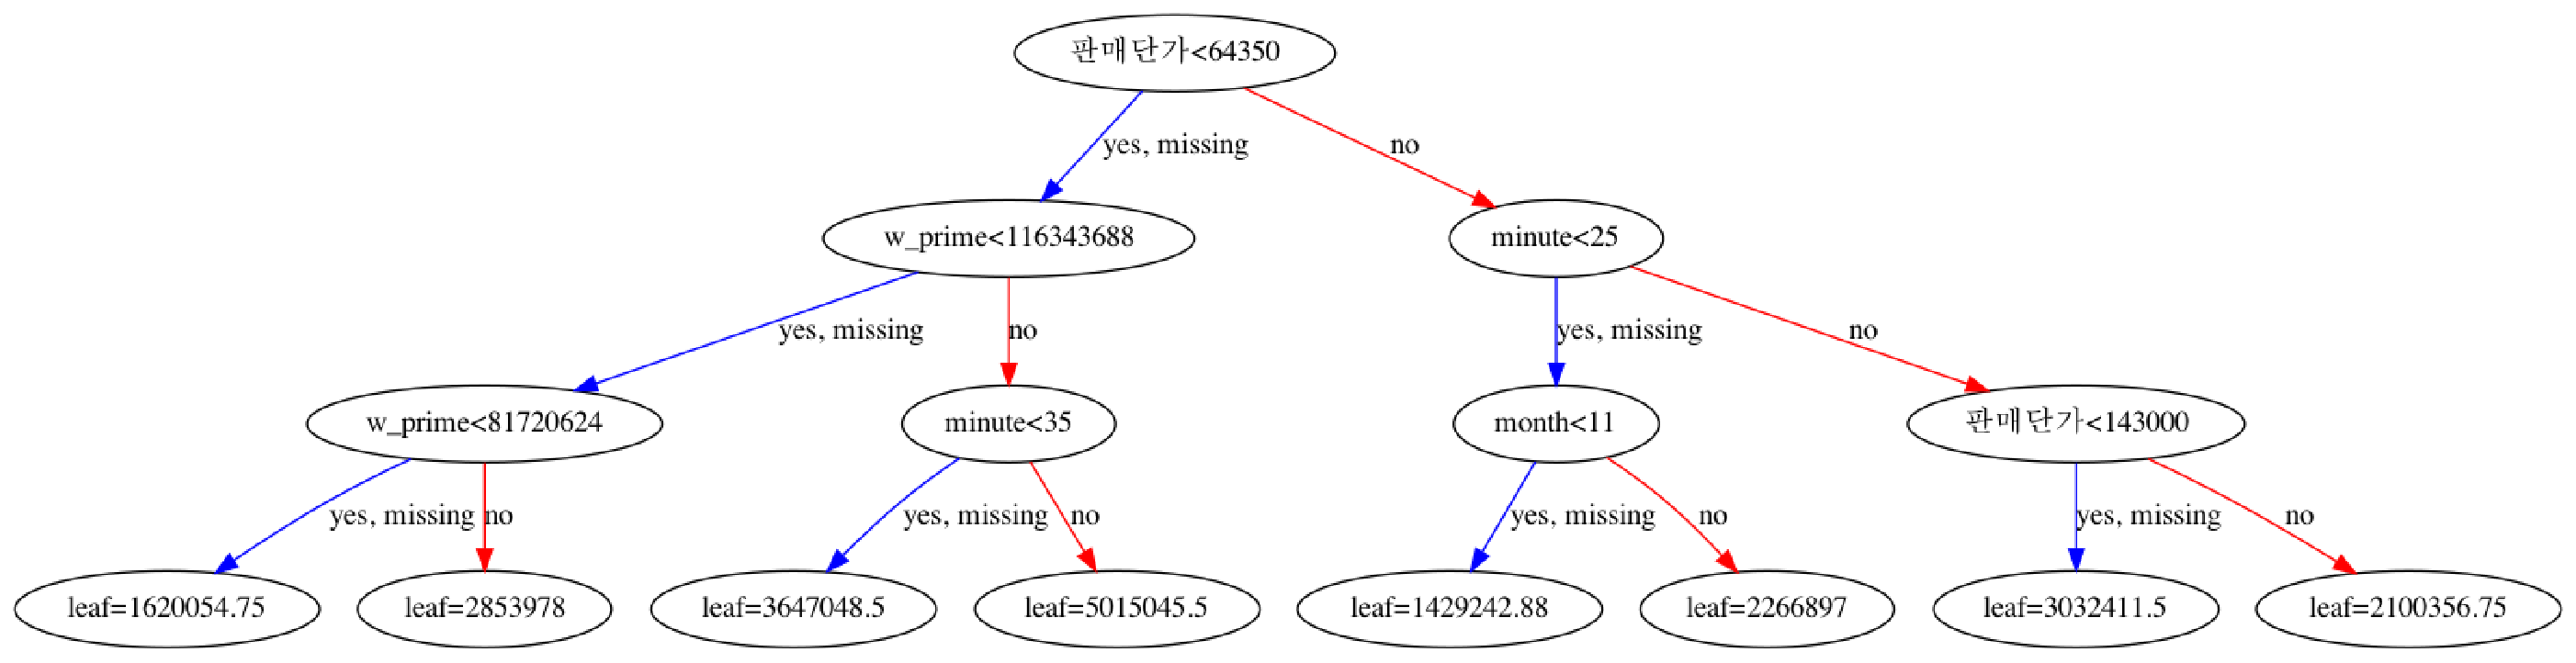

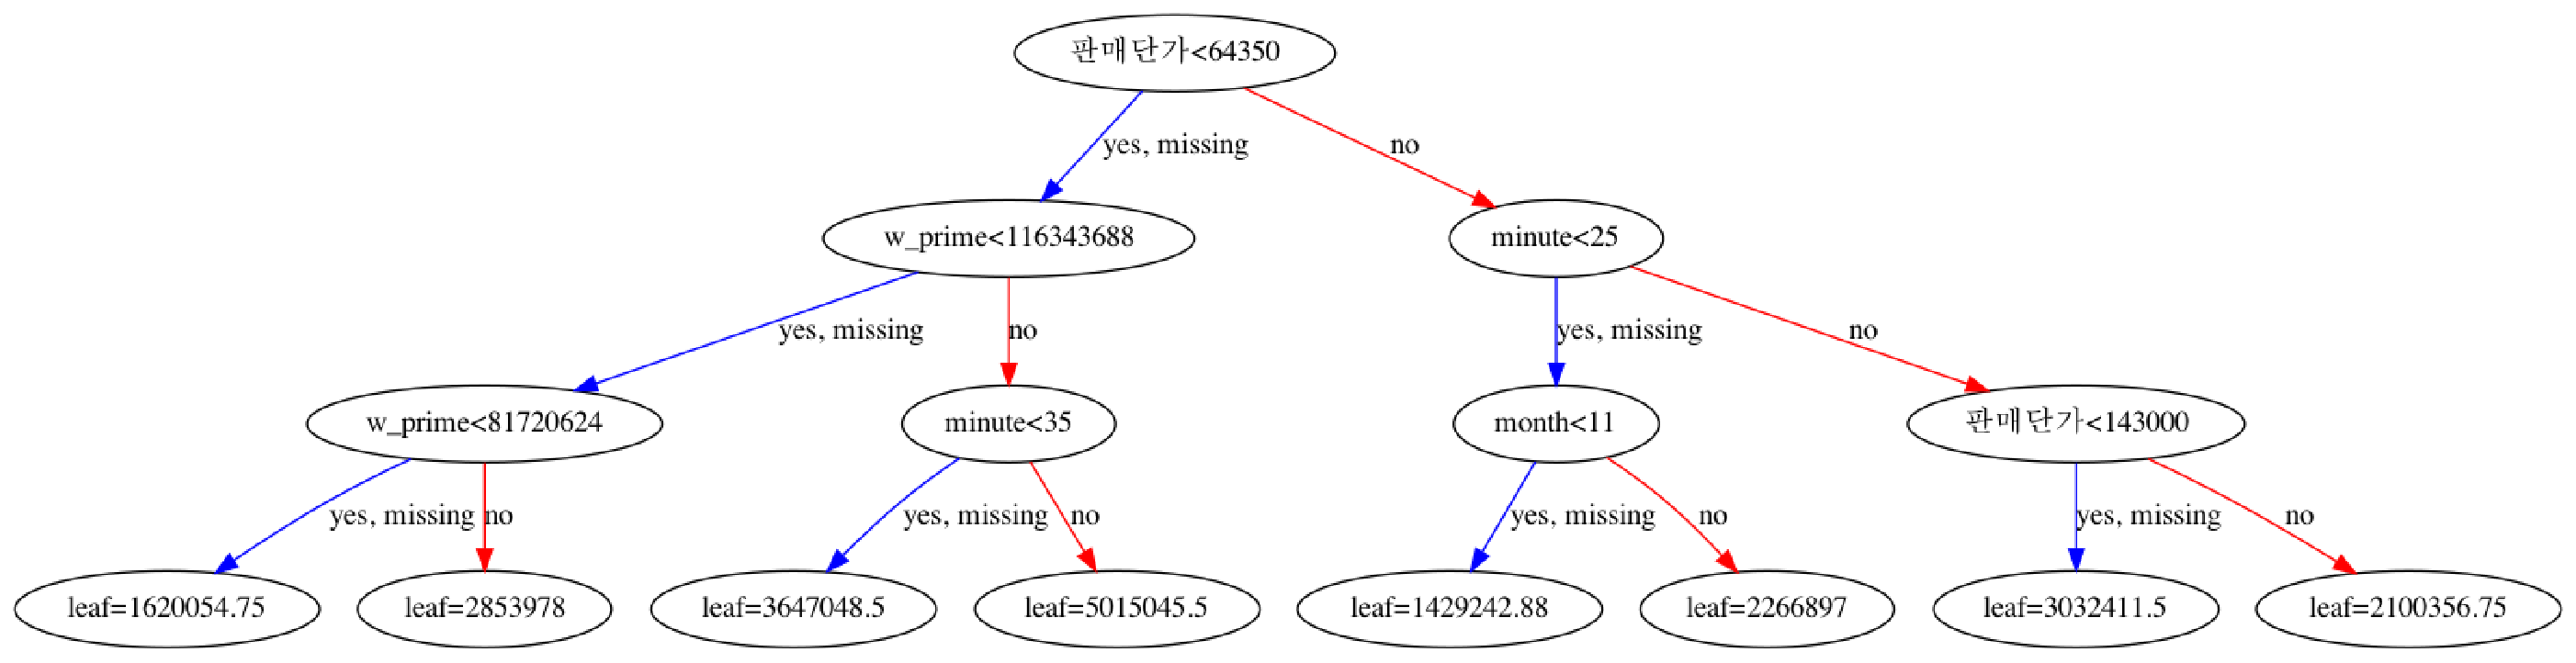

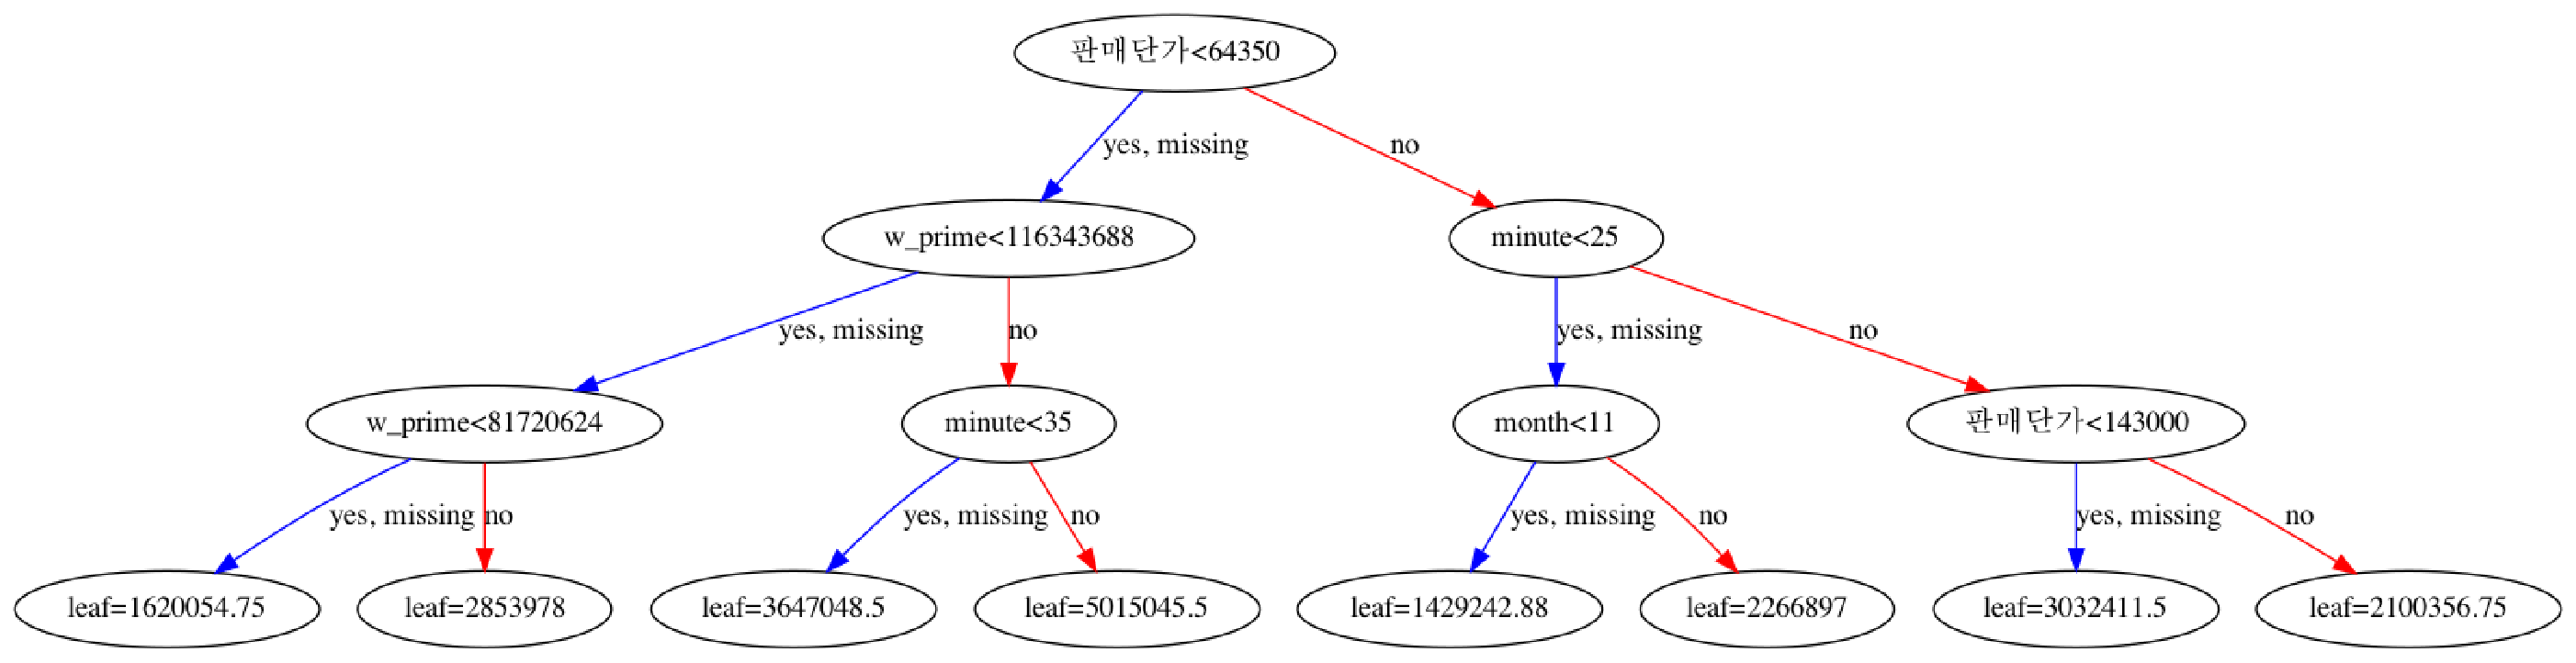

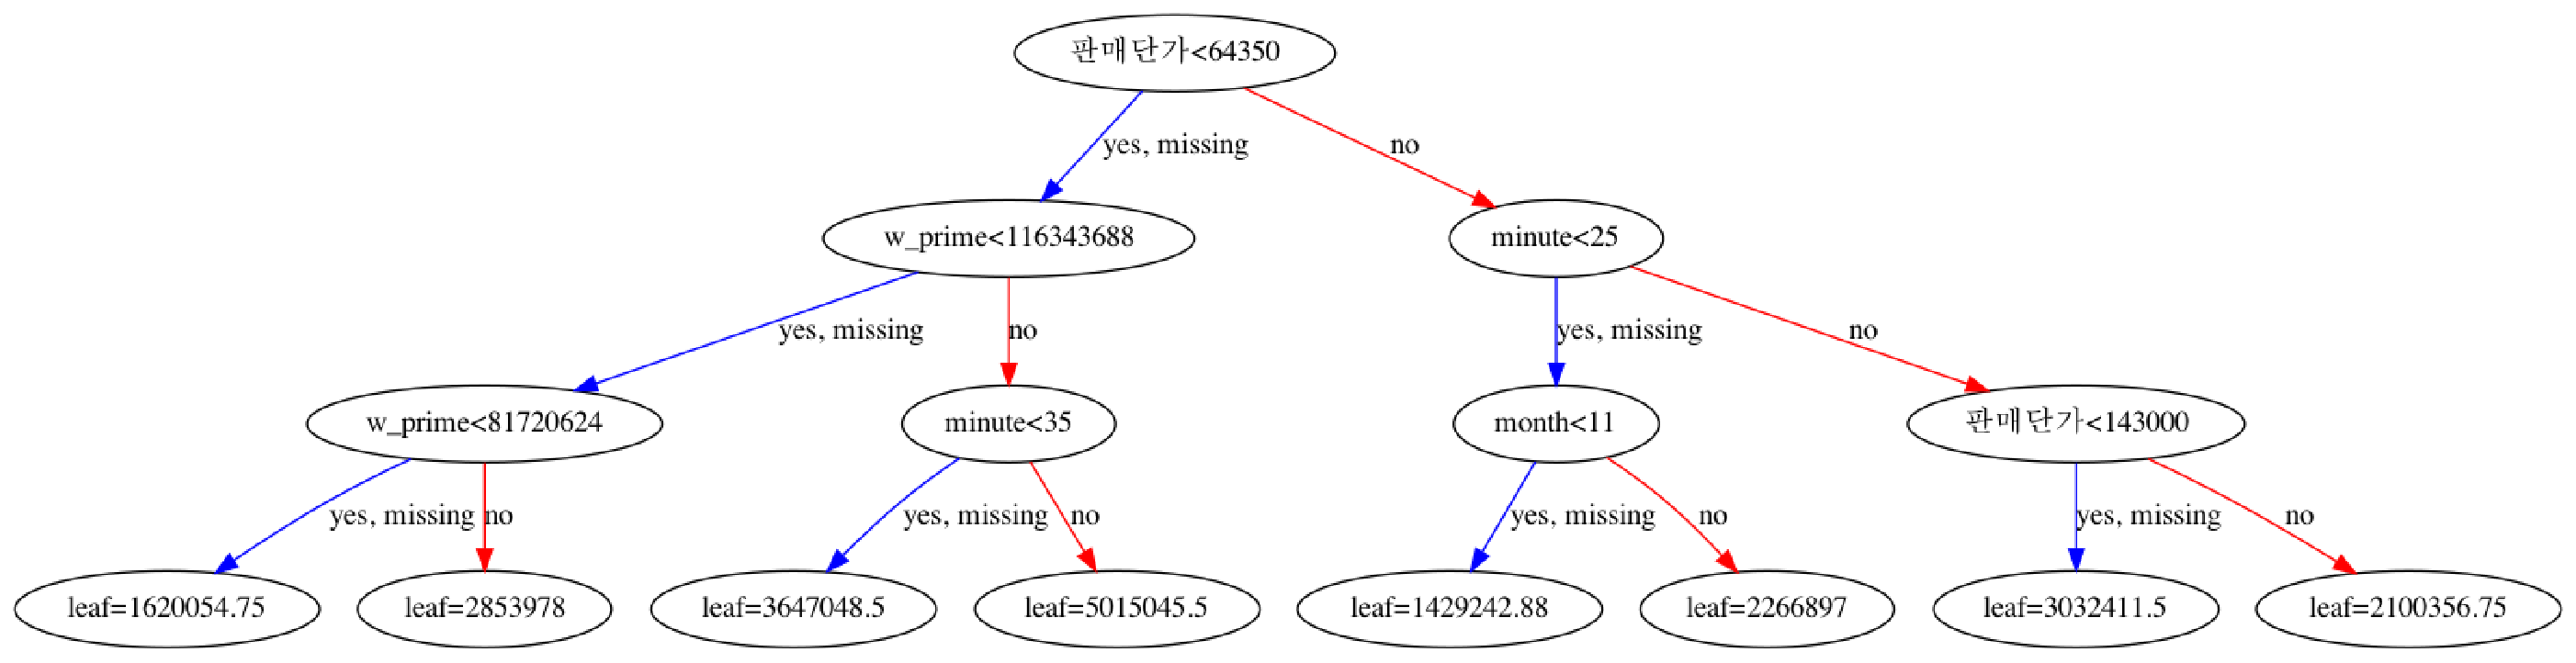

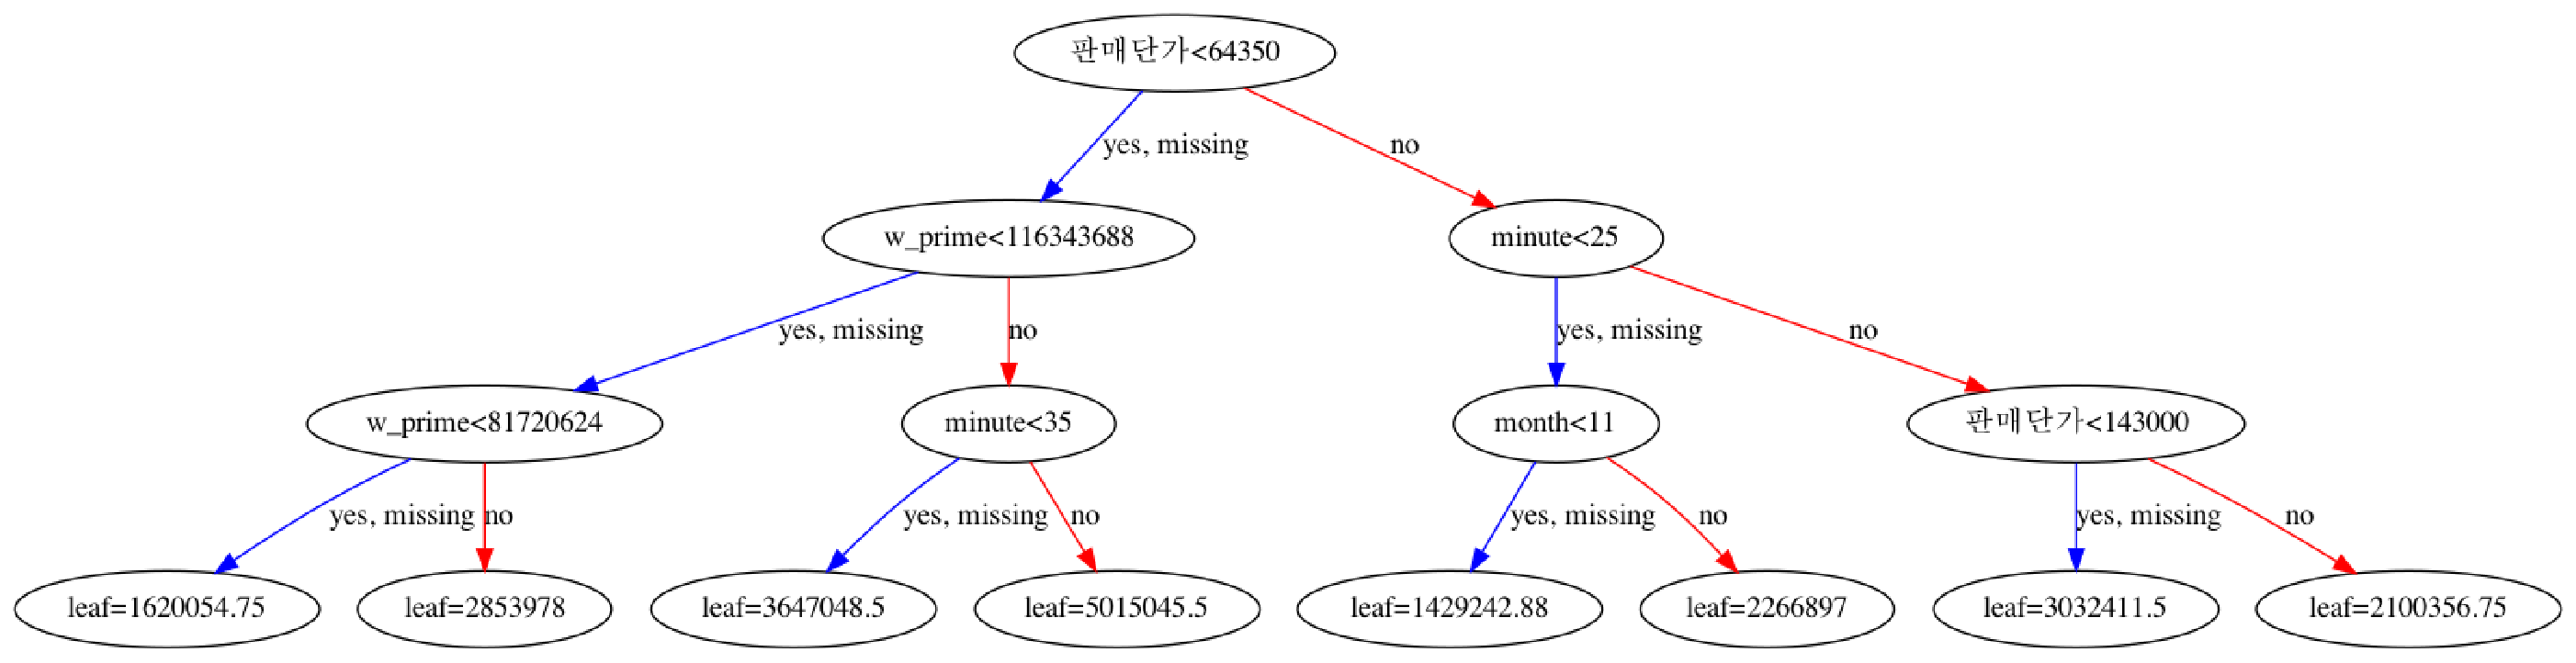

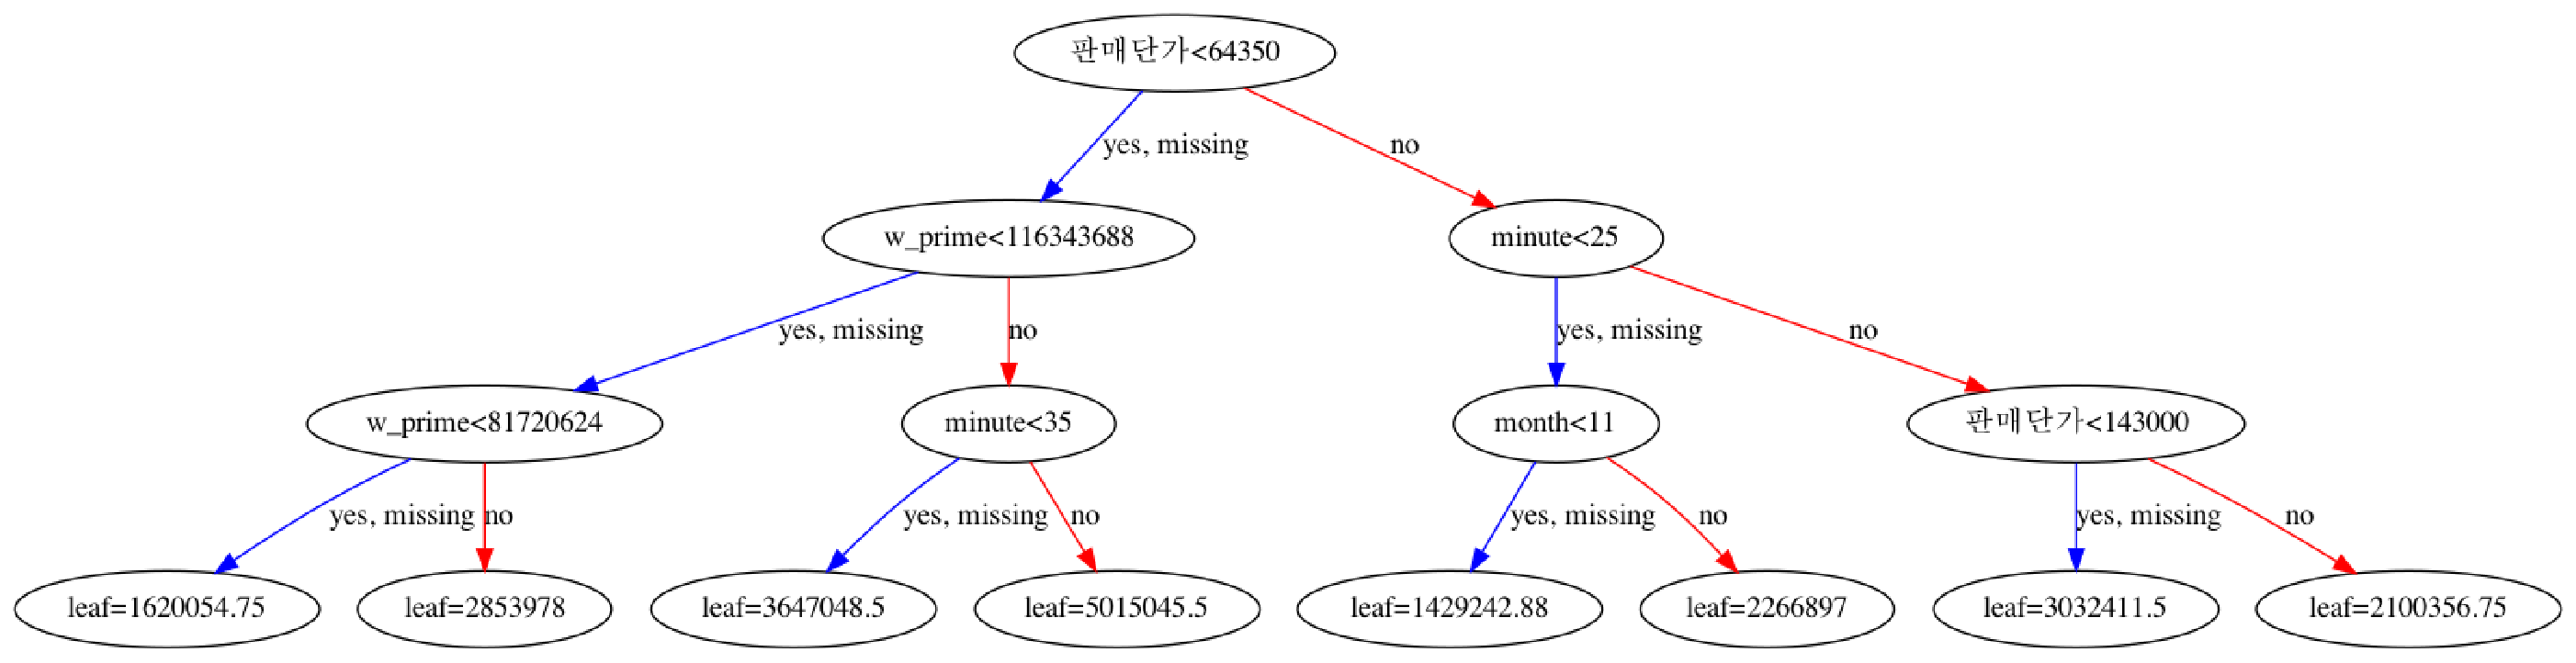

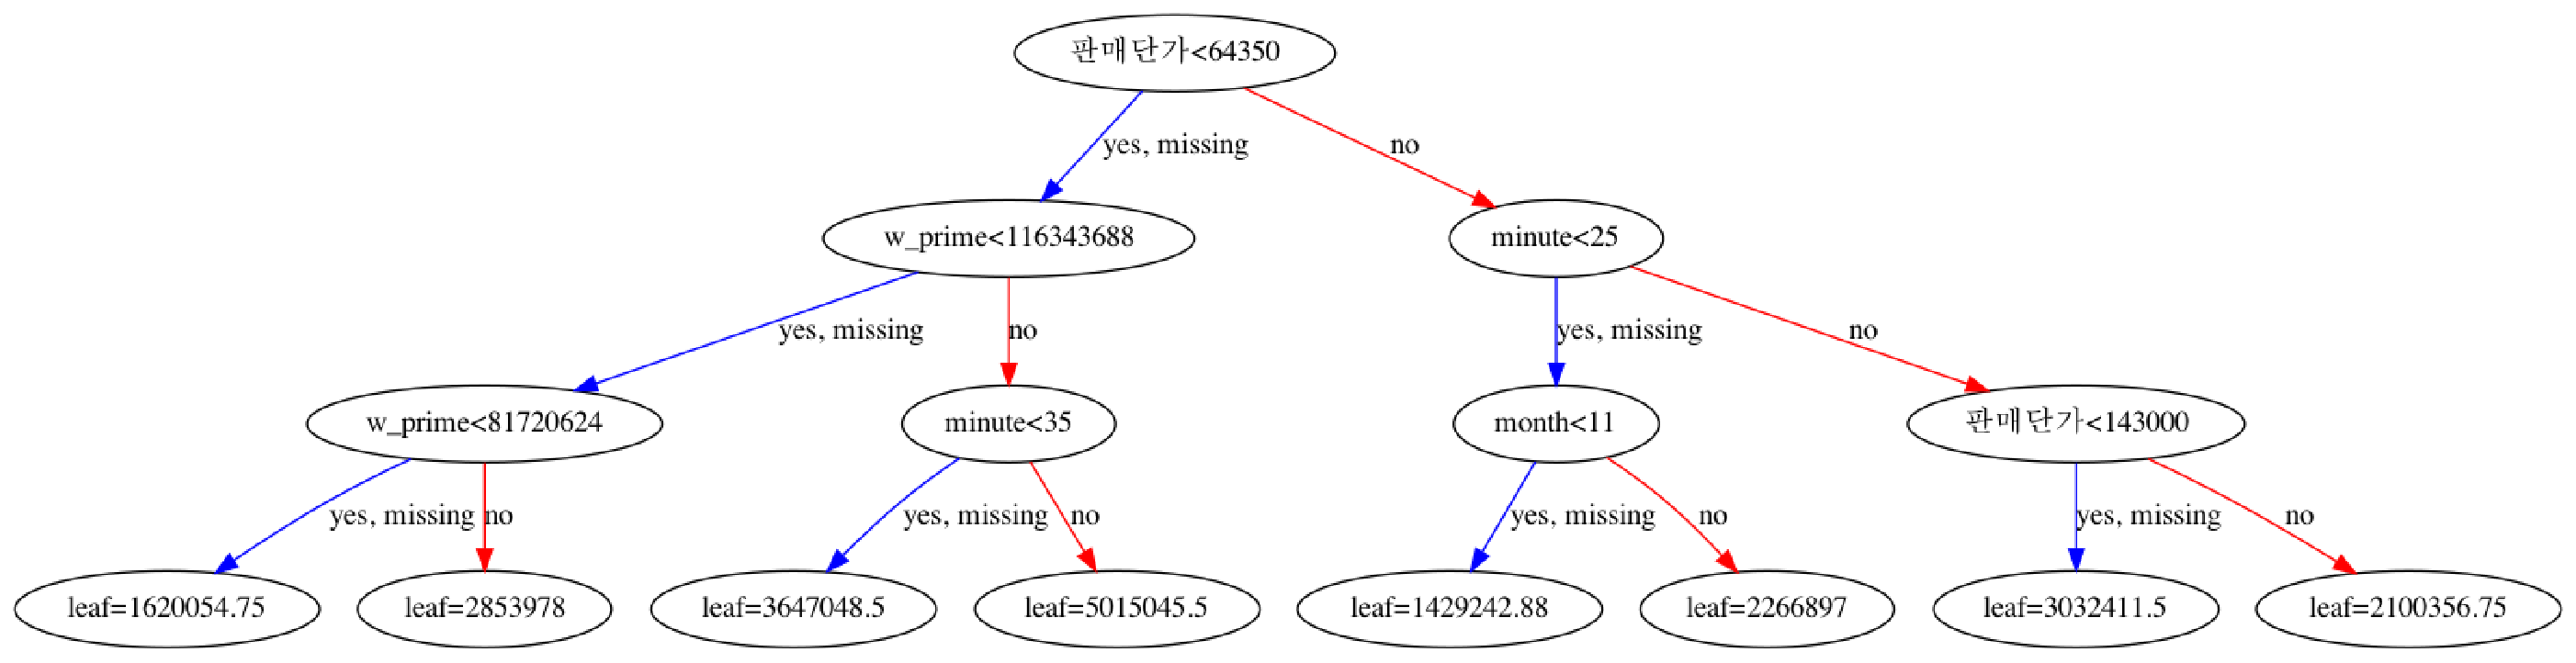

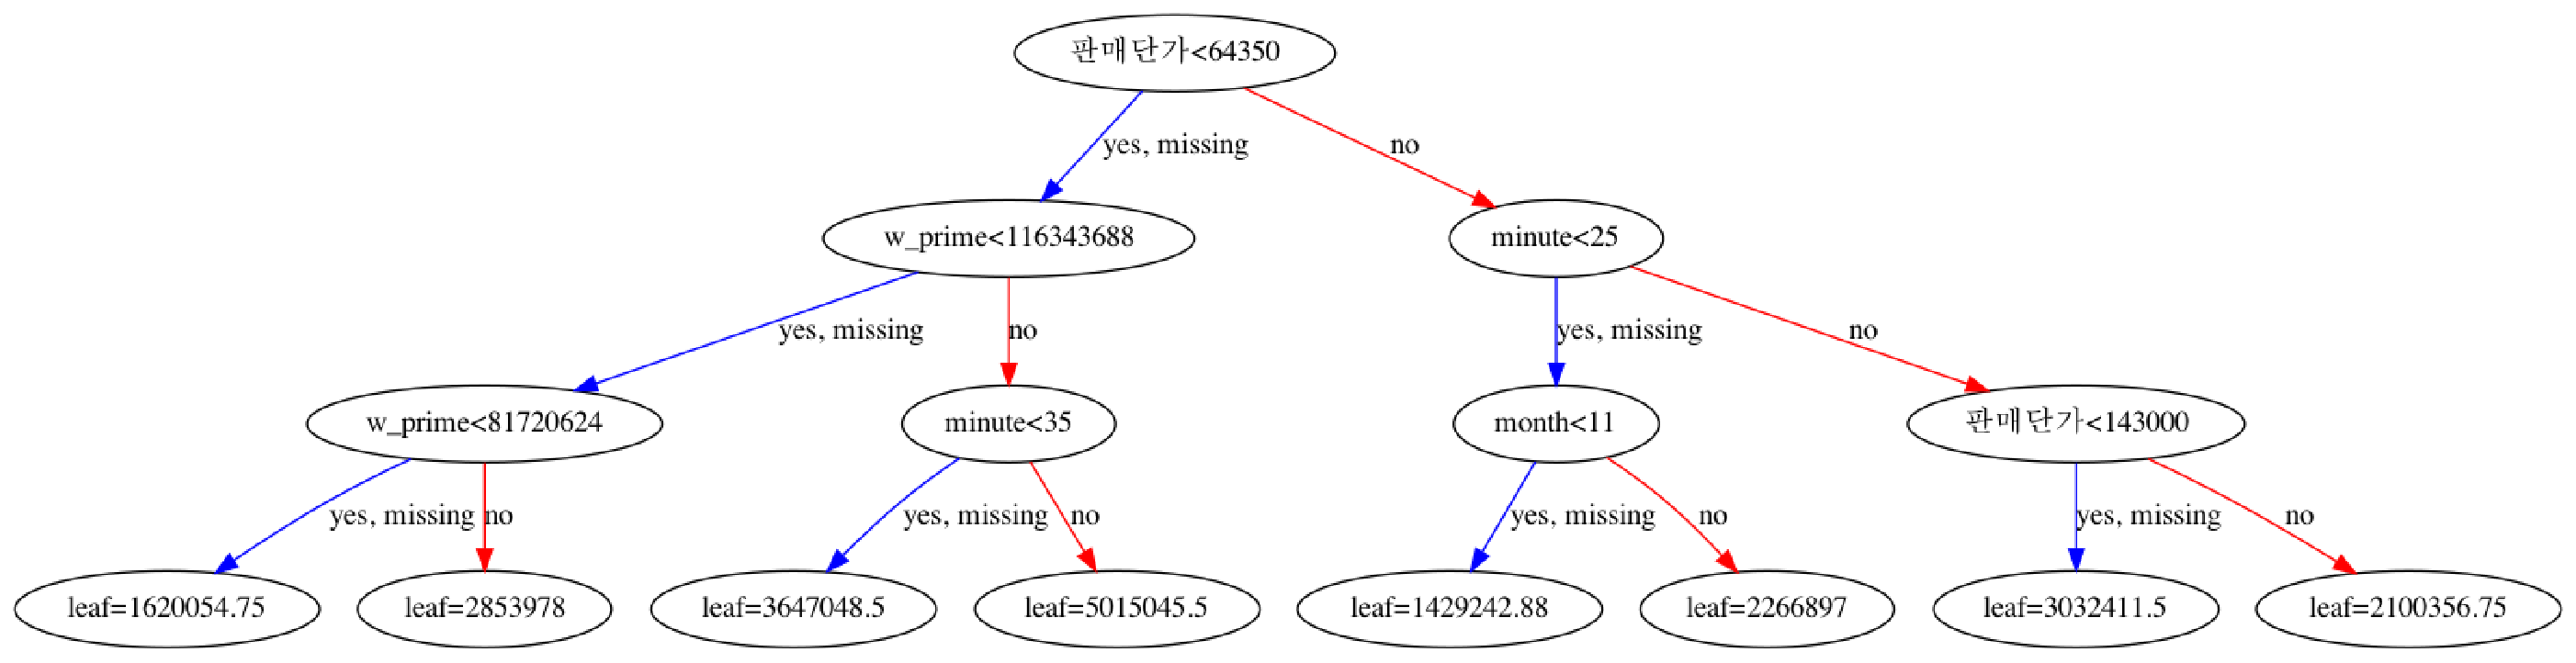

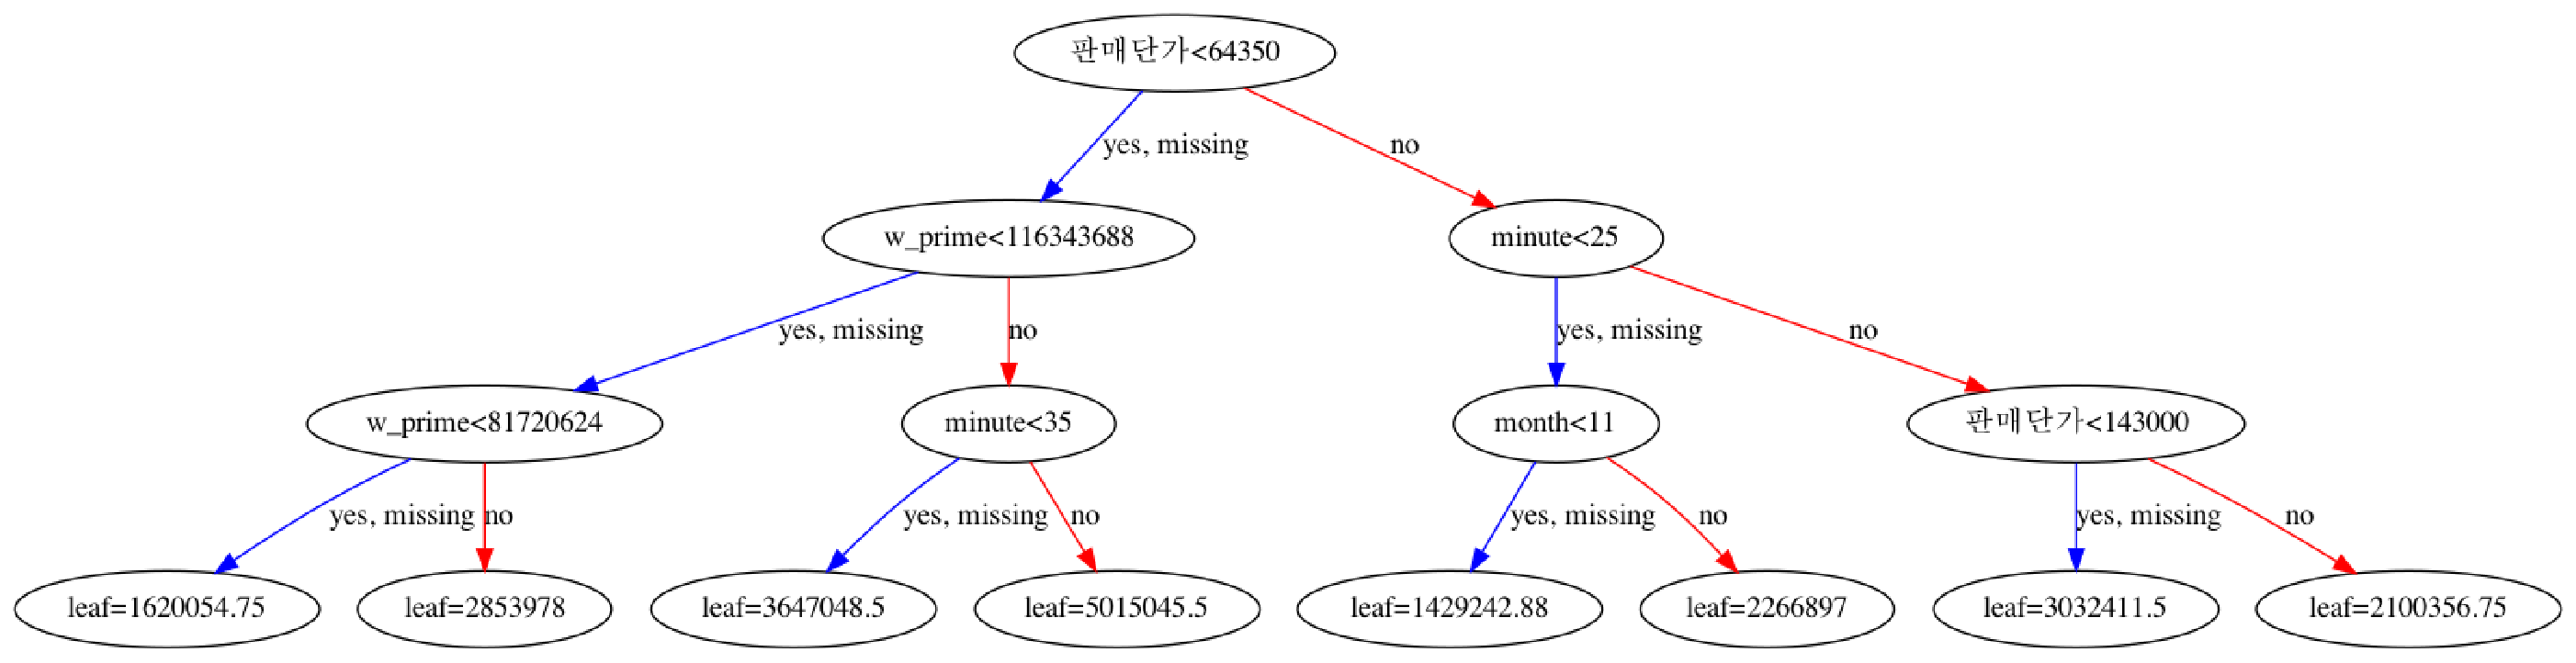

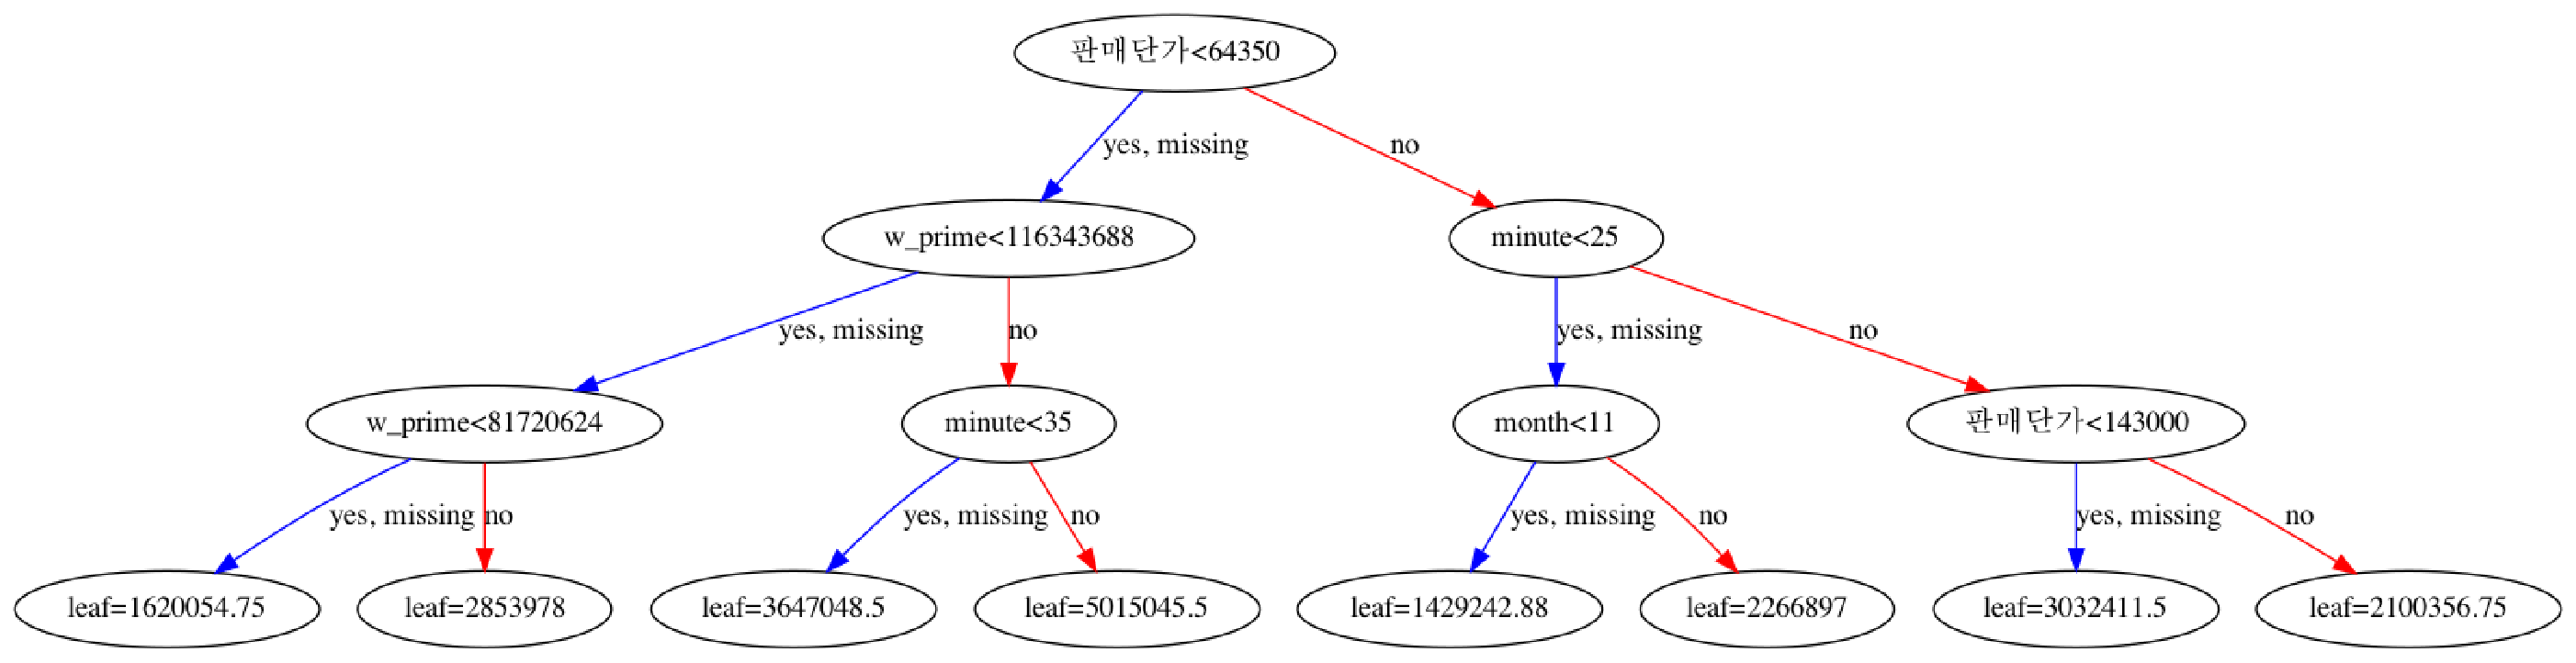

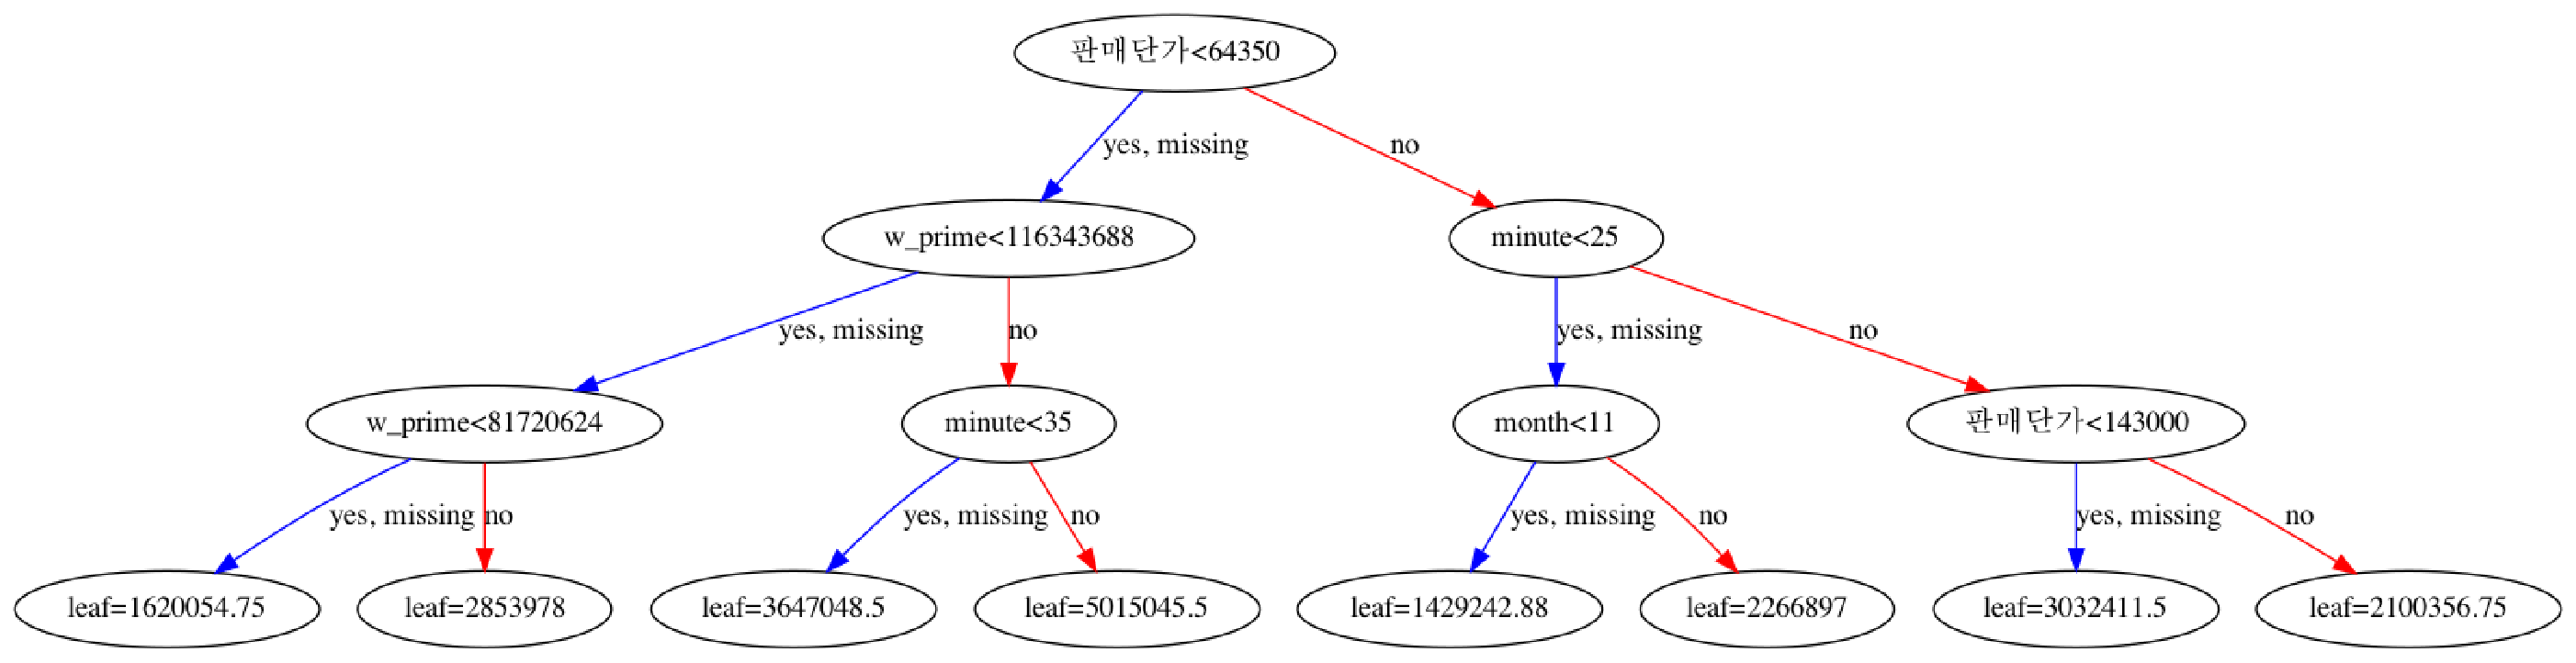

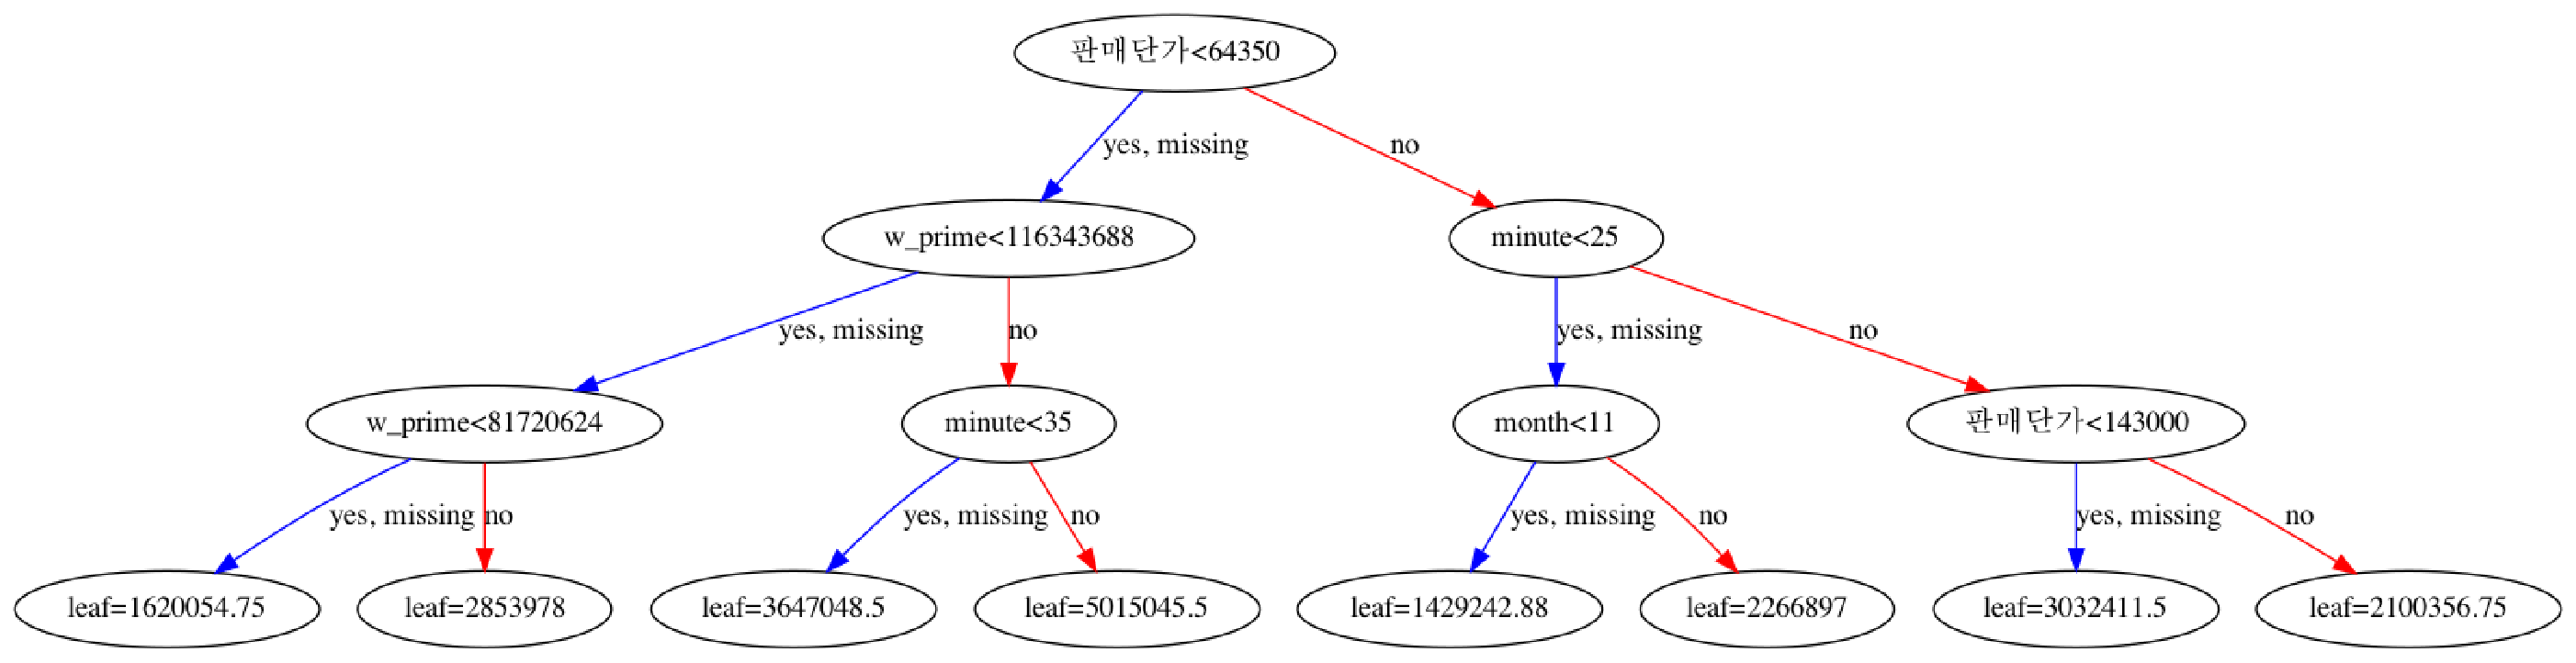

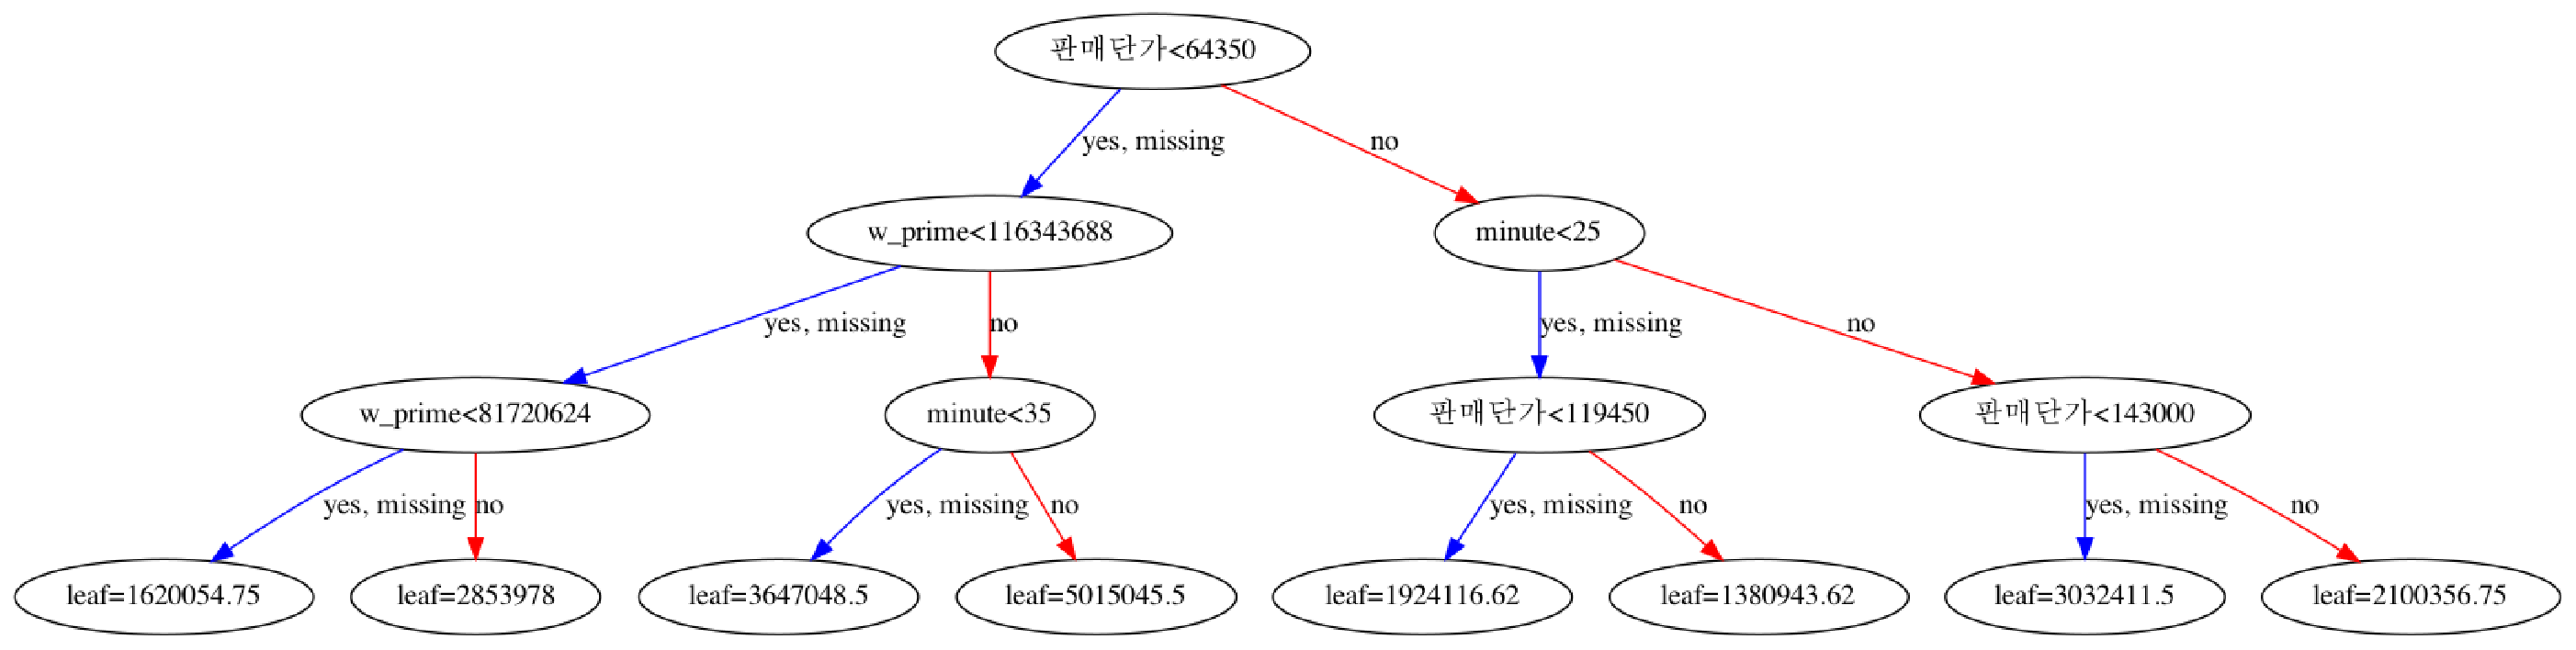

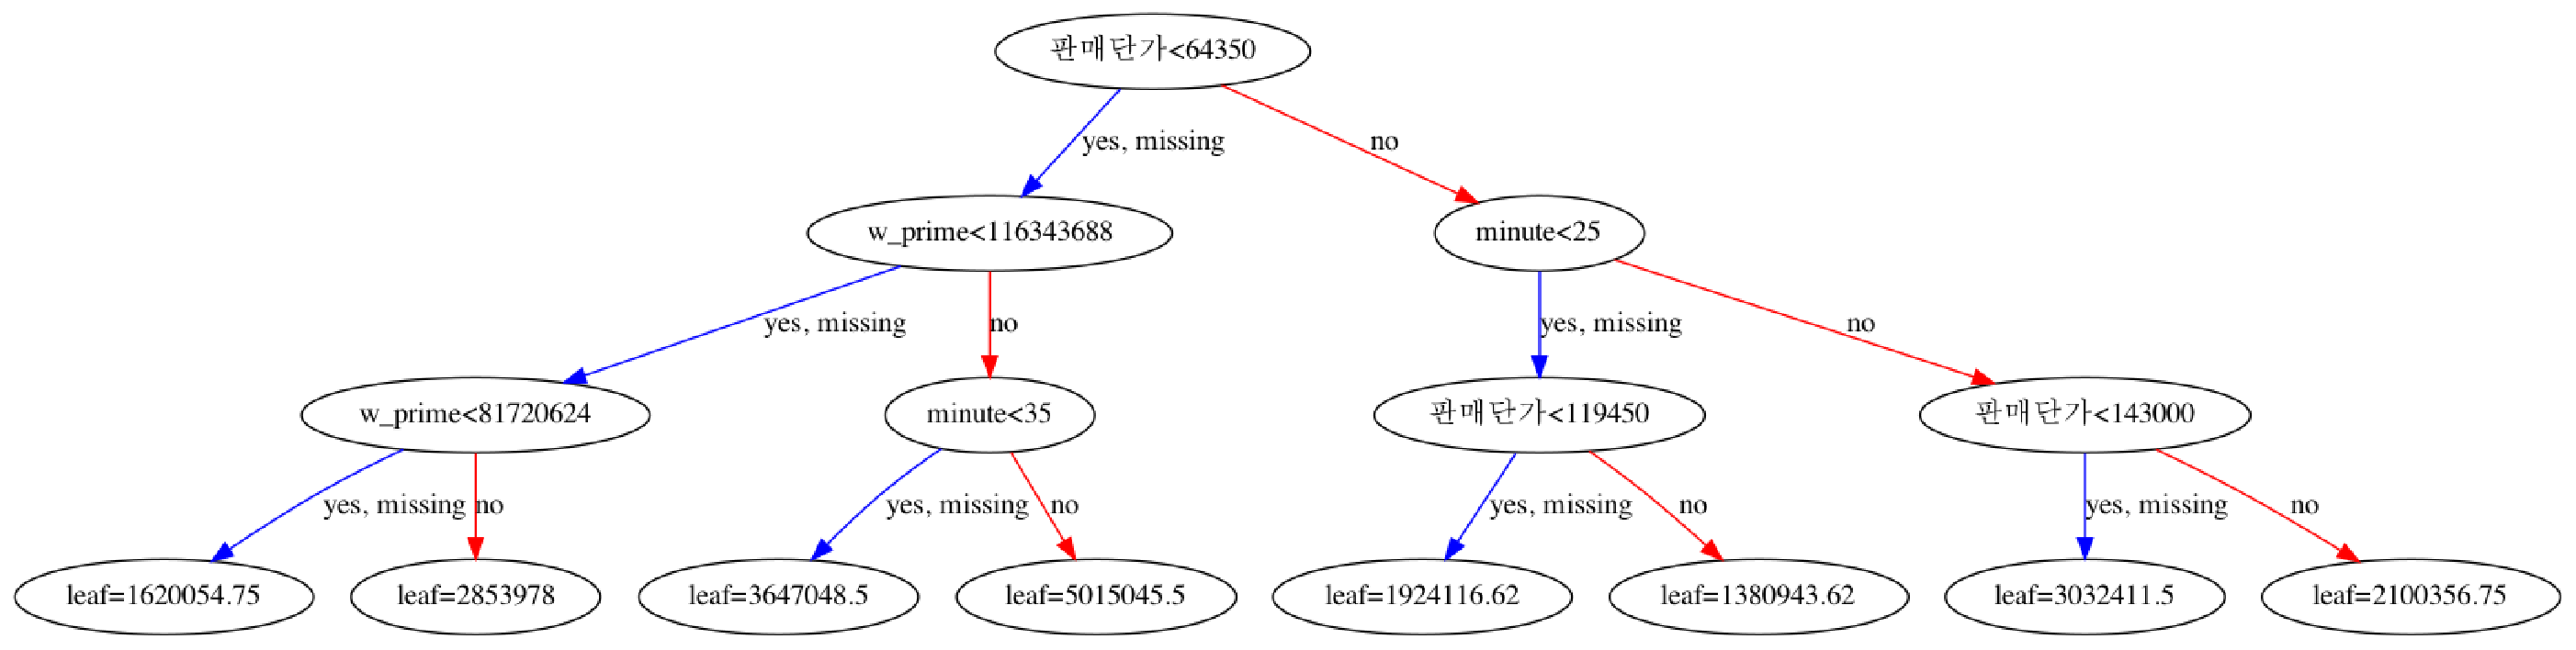

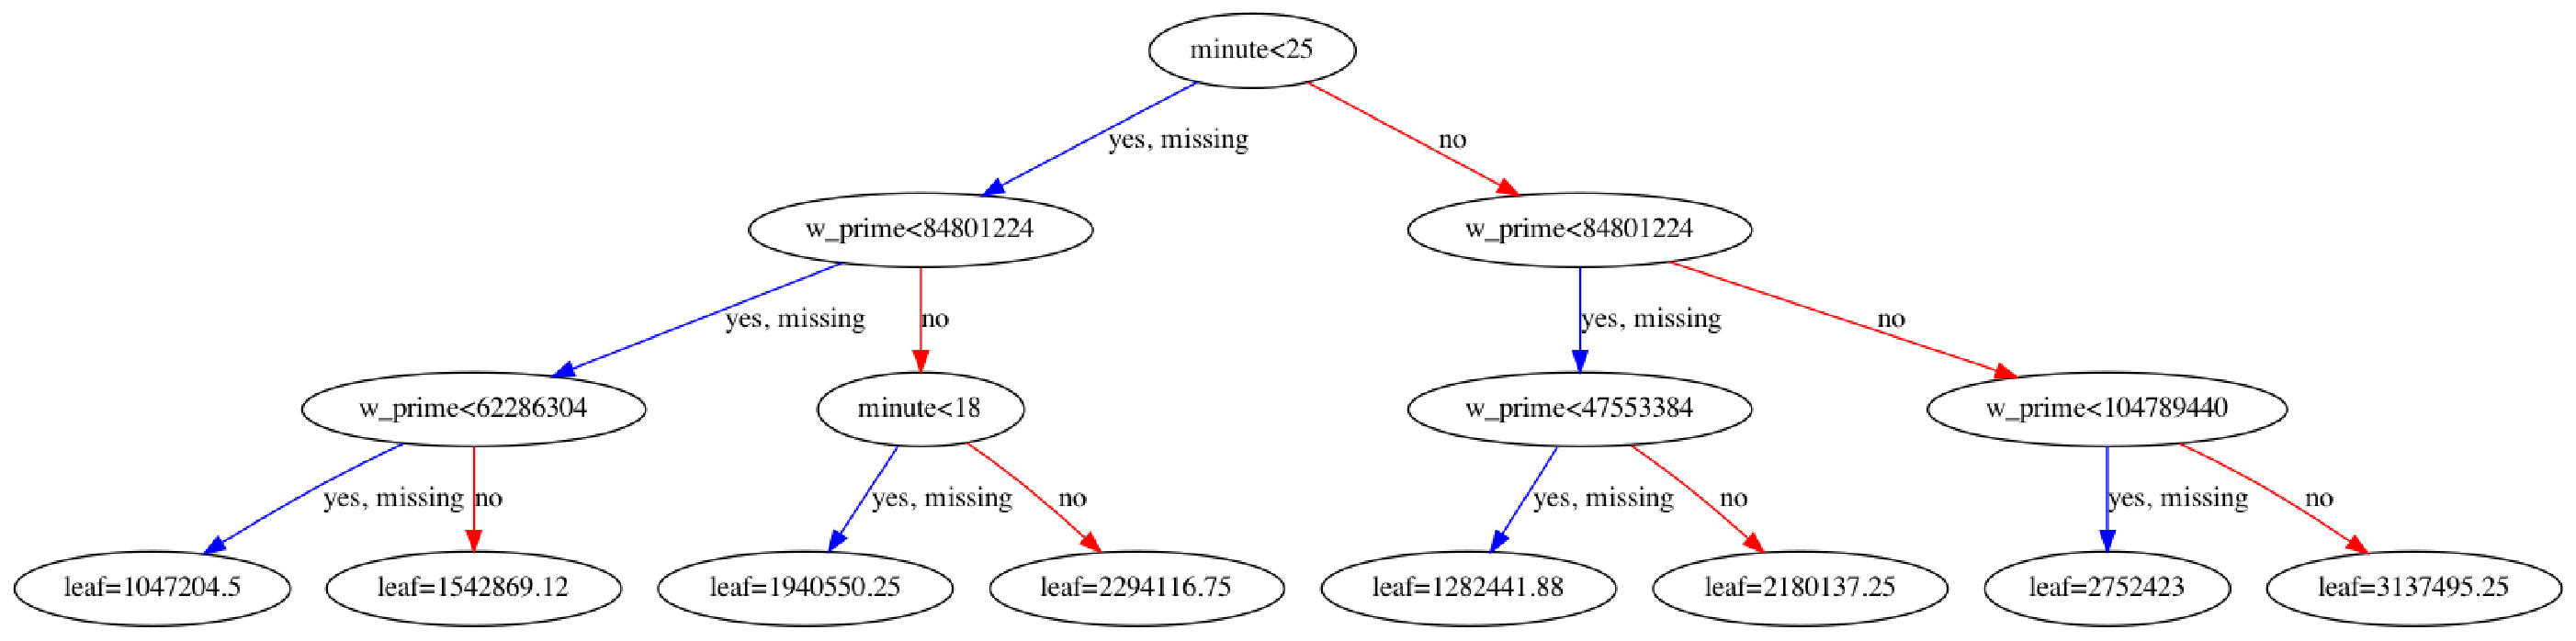

In [71]:
for n in range(len(columns), 1, -1):
    select_features = columns[:n]
    select_features = [x for x in select_features]
    select_X = df[select_features]
    select_y = df['취급액']
    X_train, X_test, y_train, y_test = train_test_split(select_X, select_y, test_size=0.1, random_state=42)

    model = XGBRegressor(objective='reg:squarederror')
    model.fit(X_train, y_train, eval_metric=['rmse','mae'])
    predictions = model.predict(X_test)
    plot_tree(model)
    fig = plt.gcf()
    fig.set_size_inches(50, 30)
    img_name = 'feature_' + str(n) + '.png'
    fig.savefig(img_name)
    print('features: {}, mape: {}'.format(n, np.mean(np.abs((y_test-predictions)/y_test))))

## feature importance 가 높은 7개를 사용했을때 mape가 가장 낮음

In [23]:
# # XGBoost 분류기 생성
# xgb_clf = xgb.XGBRegressor(objective='reg:squarederror')

# # 초모수 격자생성
# xgb_param_grid = {'max_depth': [3,5,7], 
#               'subsample': [0.6, 0.8, 1.0]}

# # Create a GridSearchCV object
# hr_grid = GridSearchCV(estimator=xgb_clf,
#                        param_grid=xgb_param_grid,
#                        scoring='neg_mean_absolute_error',
#                        n_jobs=8,
#                        cv=5,
#                        refit=True, 
#                        return_train_score=True)

# hr_grid.fit(X_train, y_train)

In [24]:
# hr_grid_df = pd.DataFrame(hr_grid.cv_results_)
# hr_grid_df.loc[:, ['mean_test_score', "params"]]

In [33]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

# def mape(actual, pred): 
#     return np.mean(np.abs((actual - pred) / actual))

# my_scorer = make_scorer(mape, greater_is_better=False)

# xgb_clf = xgb.XGBRegressor(objective='reg:squarederror')

# xgb_param_grid = {'max_depth': [3,4,5,6,7], 
#               'subsample': [0.6, 0.8, 1.0],
#                 'min_child_weight':[1,3,5],
#                  'colsample_bytree':[0.5,0.8],
#                  'colsample_bylevel':[0.9],
#                  'n_estimators':[50]}

# # Create a GridSearchCV object
# hr_grid = GridSearchCV(estimator=xgb_clf,
#                        param_grid=xgb_param_grid,
#                        scoring=my_scorer,
#                        n_jobs=2,
#                        cv=5,
#                        refit=True, 
#                        return_train_score=True)

# hr_grid.fit(X_train, y_train)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=42)

In [135]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=columns)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=columns)

In [136]:
## build basedline model

In [137]:
def mape(pred, dtrain): 
    y = dtrain.get_label()
    return 'mape', float(np.mean(np.abs((y - pred) / y)))

# Build baseline model

In [138]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'disable_default_eval_metric': 1
}
    

In [139]:
num_boost_round = 999

In [140]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    feval=mape
)

print("Best MAPE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[0]	Test-mape:0.729296
Will train until Test-mape hasn't improved in 10 rounds.
[1]	Test-mape:0.781159
[2]	Test-mape:0.87159
[3]	Test-mape:0.946369
[4]	Test-mape:0.989423
[5]	Test-mape:1.02578
[6]	Test-mape:1.03634
[7]	Test-mape:1.056
[8]	Test-mape:1.05934
[9]	Test-mape:1.05839
[10]	Test-mape:1.06248
Stopping. Best iteration:
[0]	Test-mape:0.729296

Best MAPE: 0.73 with 1 rounds


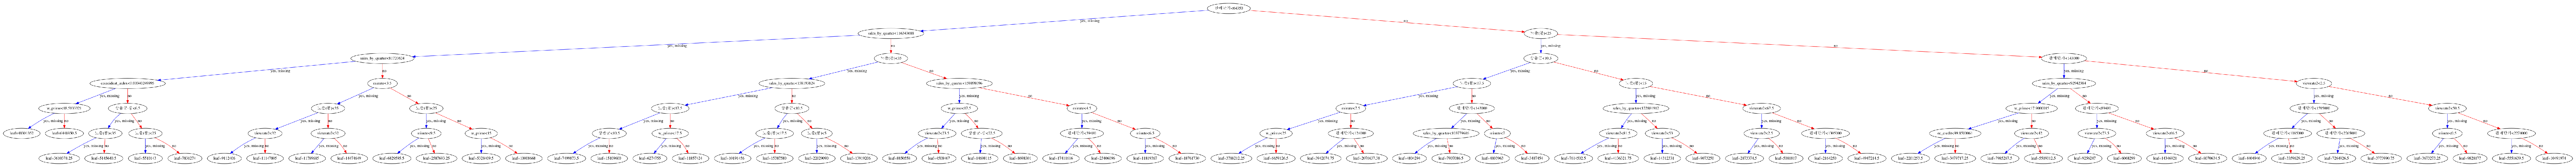

In [141]:
from xgboost import plot_tree
import sys
# !/opt/anaconda3/bin/python -m pip install graphviz
# sys.executable
import graphviz
import os
# os.environ["PATH"] += os.pathsep + '/opt/anaconda3/bin/python'
# sys.path
plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')
# !conda install graphviz

## cv 적용

In [158]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    early_stopping_rounds=10,
    feval=mape
    
)
cv_results

train-mape-mean  train-mape-std  test-mape-mean  test-mape-std
0         0.703017        0.003439        0.704878       0.012755

In [159]:
cv_results['test-mape-mean'].min()

0.7048778

# Hyperparameter tuning
1. max_depth: 과적합 방지를 위해서 사용되는데 역시 CV를 사용해서 적절한 값이 제시되어야 하고 보통 3-10 사이 값이 적용된다.
2. min_child_weight: 과적합(overfitting)을 방지할 목적으로 사용되는데, 너무 높은 값은 과소적합(underfitting)을 야기하기 때문에 CV를 사용해서 적절한 값이 제시되어야 한다.
3. eta: GBM에 학습율과 유사하고 일반적으로 0.01 ~ 0.2 값이 사용됨
4. subsample: 개별 의사결정나무 모형에 사용되는 임의 표본수를 지정. 보통 0.5 ~ 1 사용됨.
5. colsample_bytree: 개별 의사결정나무 모형에 사용될 변수갯수를 지정. 보통 0.5 ~ 1 사용됨.
5. number of boosting rounds: 부스팅 횟수

## max_depth & min_child

In [160]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(10,15)
    for min_child_weight in range(1,8)
]

In [161]:
# Define initial best params and MAPE
min_mape = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        early_stopping_rounds=10,
        feval=mape

    )
    # Update best MAPE
    mean_mape = cv_results['test-mape-mean'].min()
    boost_rounds = cv_results['test-mape-mean'].argmin()
    print("\tMAPE {} for {} rounds".format(mean_mape, boost_rounds))
    if mean_mape < min_mape:
        min_mape = mean_mape
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAPE: {}".format(best_params[0], best_params[1], min_mape))

CV with max_depth=10, min_child_weight=1
	MAPE 0.6386860000000001 for 1 rounds
CV with max_depth=10, min_child_weight=2
	MAPE 0.637782 for 1 rounds
CV with max_depth=10, min_child_weight=3
	MAPE 0.6402197999999999 for 1 rounds
CV with max_depth=10, min_child_weight=4
	MAPE 0.6404806000000001 for 1 rounds
CV with max_depth=10, min_child_weight=5
	MAPE 0.6415208 for 1 rounds
CV with max_depth=10, min_child_weight=6
	MAPE 0.6483331999999999 for 1 rounds
CV with max_depth=10, min_child_weight=7
	MAPE 0.647861 for 1 rounds
CV with max_depth=11, min_child_weight=1
	MAPE 0.6238602 for 1 rounds
CV with max_depth=11, min_child_weight=2
	MAPE 0.6234604 for 1 rounds
CV with max_depth=11, min_child_weight=3
	MAPE 0.6230168 for 1 rounds
CV with max_depth=11, min_child_weight=4
	MAPE 0.6274694000000001 for 1 rounds
CV with max_depth=11, min_child_weight=5
	MAPE 0.6274803999999999 for 1 rounds
CV with max_depth=11, min_child_weight=6
	MAPE 0.6325308 for 1 rounds
CV with max_depth=11, min_child_weight

In [162]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

## subsample & colsample_bytree

In [163]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [164]:
min_mae = float("Inf")
best_params = (1.0, 1.0)
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        early_stopping_rounds=10,
        feval=mape
    )
    # Update best score
    mean_mape = cv_results['test-mape-mean'].min()
    boost_rounds = cv_results['test-mape-mean'].argmin()
    print("\tMAPE {} for {} rounds".format(mean_mape, boost_rounds))
    if mean_mape < min_mape:
        min_mape = mean_mape
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, MAPE: {}".format(best_params[0], best_params[1], min_mape))

CV with subsample=1.0, colsample=1.0
	MAPE 0.5972632000000001 for 2 rounds
CV with subsample=1.0, colsample=0.9
	MAPE 0.5769986 for 2 rounds
CV with subsample=1.0, colsample=0.8
	MAPE 0.5705600000000001 for 2 rounds
CV with subsample=1.0, colsample=0.7
	MAPE 0.5874372 for 2 rounds
CV with subsample=0.9, colsample=1.0
	MAPE 0.6004868 for 2 rounds
CV with subsample=0.9, colsample=0.9
	MAPE 0.5955518 for 2 rounds
CV with subsample=0.9, colsample=0.8
	MAPE 0.5807794000000001 for 2 rounds
CV with subsample=0.9, colsample=0.7
	MAPE 0.5933035999999999 for 2 rounds
CV with subsample=0.8, colsample=1.0
	MAPE 0.614455 for 2 rounds
CV with subsample=0.8, colsample=0.9
	MAPE 0.6111708 for 2 rounds
CV with subsample=0.8, colsample=0.8
	MAPE 0.5895421999999999 for 2 rounds
CV with subsample=0.8, colsample=0.7
	MAPE 0.6046234 for 1 rounds
CV with subsample=0.7, colsample=1.0
	MAPE 0.6126408 for 2 rounds
CV with subsample=0.7, colsample=0.9
	MAPE 0.6229182 for 2 rounds
CV with subsample=0.7, colsample

In [165]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

## eta

In [166]:
min_mape = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta

    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            early_stopping_rounds=10,
            feval=mape
            )
    # Update best score
    mean_mape = cv_results['test-mape-mean'].min()
    boost_rounds = cv_results['test-mape-mean'].argmin()
    print("\tMAPE {} for {} rounds\n".format(mean_mape, boost_rounds))
    if mean_mape < min_mape:
        min_mape = mean_mape
        best_params = eta
print("Best params: {}, MAPE: {}".format(best_params, min_mape))

CV with eta=0.3
	MAPE 0.5705600000000001 for 2 rounds

CV with eta=0.2
	MAPE 0.5627344 for 3 rounds

CV with eta=0.1
	MAPE 0.5519724 for 9 rounds

CV with eta=0.05
	MAPE 0.5512126 for 19 rounds

CV with eta=0.01
	MAPE 0.558151 for 96 rounds

CV with eta=0.005
	MAPE 0.5588110000000001 for 198 rounds

Best params: 0.05, MAPE: 0.5512126


In [167]:
params['eta'] = best_params

## best parameters results

In [95]:
params

In [ ]:
num_boost_round=21

In [ ]:
# params = {'max_depth': 14,
#  'min_child_weight': 1,
#  'eta': 0.05,
#  'subsample': 1.0,
#  'colsample_bytree': 0.8,
#  'objective': 'reg:squarederror',
#  'disable_default_eval_metric': 1}

In [96]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10,
    feval=mape
)

print("Best MAPE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))
plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(300, 200)
fig.savefig('tree.png')

[0]	Test-mape:0.927387
Will train until Test-mape hasn't improved in 10 rounds.
[1]	Test-mape:0.865203
[2]	Test-mape:0.809396
[3]	Test-mape:0.764564
[4]	Test-mape:0.722568
[5]	Test-mape:0.691113
[6]	Test-mape:0.665224
[7]	Test-mape:0.643761
[8]	Test-mape:0.620201
[9]	Test-mape:0.604989
[10]	Test-mape:0.591264
[11]	Test-mape:0.584253
[12]	Test-mape:0.571258
[13]	Test-mape:0.560919
[14]	Test-mape:0.553837
[15]	Test-mape:0.547562
[16]	Test-mape:0.547503
[17]	Test-mape:0.545407
[18]	Test-mape:0.544999
[19]	Test-mape:0.546617
[20]	Test-mape:0.544952
Best MAPE: 0.54 in 21 rounds


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.231302 to fit


SystemError: <built-in method write of _io.BufferedWriter object at 0x7fbbccb4b350> returned a result with an error set

Error in callback <function flush_figures at 0x7fbbc81104d0> (for post_execute):


KeyboardInterrupt: 

In [76]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    early_stopping_rounds=10,
    feval=mape
    
)
cv_results

KeyboardInterrupt: 

## 가장 중요한 feature 7개로 학습

In [175]:
select_features = columns[:7]
select_features = [x for x in select_features]
select_X = df[select_features]
select_y = df['취급액']
X_train, X_test, y_train, y_test = train_test_split(select_X, select_y, test_size=0.1, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    early_stopping_rounds=10,
    feval=mape
    
)
cv_results

train-mape-mean  train-mape-std  test-mape-mean  test-mape-std
0          0.933678        0.000483        0.929468       0.001283
1          0.870684        0.003563        0.866101       0.002735
2          0.814738        0.004314        0.811489       0.003510
3          0.761586        0.005564        0.760791       0.001940
4          0.716920        0.004651        0.719919       0.003510
5          0.678167        0.003099        0.684999       0.004089
6          0.644640        0.002014        0.655296       0.005739
7          0.614563        0.003100        0.630351       0.007960
8          0.590004        0.004718        0.611626       0.010464
9          0.568744        0.006526        0.596881       0.012691
10         0.549660        0.008699        0.583763       0.012416
11         0.533897        0.009232        0.574331       0.013993
12         0.517650        0.010260        0.564228       0.015027
13         0.504433        0.010746        0.557128       0.014830
14         0.493885        0.012615        0.552569       0.015385
15         0.483567        0.012403        0.548261       0.013684
16         0.475683        0.013044        0.545909       0.014206
17         0.466446        0.012380        0.543720       0.014666
18         0.460740        0.014333        0.542588       0.017459
19         0.455645        0.014381        0.543607       0.017872
20         0.451586        0.015057        0.544885       0.020027